## Main Jupyter Notebooks for implementing the German Traffic Sign Classification CNN

# Read in Data

In [7]:
# Imports 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt

In [8]:
# Gibt an, ob wir auf einer GPU oder CPU trainieren 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [9]:
# Hier wird unser mean und unser std für die Normalisierung der Bilder berechnet
# dataset = ImageFolder("GTSRB\Final_Training\Images", transform=transforms.ToTensor())
transform_mean_std = transforms.Compose([
    transforms.Resize((35, 35)),  
    transforms.ToTensor(),
])
dataset = ImageFolder("C:/Users/v814u63/Documents/Uni/5. Semester/XAI/images/train_images", transform=transform_mean_std)
loader = DataLoader(dataset, batch_size=64, shuffle=False)

mean = 0.
std = 0.
total_images_count = 0

for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images_count += batch_samples

mean /= total_images_count
std /= total_images_count

print(f"Mean: {mean}")
print(f"Std: {std}")


Mean: tensor([0.3403, 0.3122, 0.3215])
Std: tensor([0.1604, 0.1600, 0.1694])


In [10]:
# transform definieren zum Einlesen der Test- und Trainingsdaten
img_size = 35 
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),  
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist()) 
])

train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomRotation(20),  # Zufällige Rotation um ±20 Grad
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),  # Zufälliges Zuschneiden und Skalieren
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  # Helligkeit und Farbvariation
    transforms.RandomHorizontalFlip(),  # Zufälliges horizontales Spiegeln
    transforms.ToTensor(),  # Umwandlung zu einem Tensor
    transforms.Normalize(mean.tolist(), std.tolist())  # Normalisierung
])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3422389..4.2980943].


Label: 30_kmh


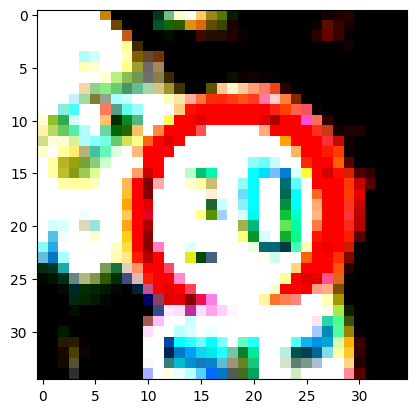

In [5]:
# Einlesen der Daten und anschließende Ausgabe eines Bildes inkl. Label zur überprüfung
train_dataset = ImageFolder(root='C:/Users/v814u63/Documents/Uni/5. Semester/XAI/images/train_images', transform=transform)
train_transforms_dataset = ImageFolder(root='C:/Users/v814u63/Documents/Uni/5. Semester/XAI/images/train_images', transform=train_transforms)

test_dataset = ImageFolder(root='C:/Users/v814u63/Documents/Uni/5. Semester/XAI/images/test_images', transform=transform)

batch_size = 64
test_loader = DataLoader(test_dataset, batch_size= batch_size, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True)
num_classes = 43
# --------- Testing ---------
img, label = train_dataset[4000]
label_string = test_dataset.classes[label]
print("Label:", label_string)
plt.imshow(img.permute(1, 2, 0))
#print(img)


# Create the Model


In [ ]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        # Convolutional Layers
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, padding=1)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_layer2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=4, padding=1)
        self.relu2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_layer3 = nn.Conv2d(in_channels=192, out_channels=384, kernel_size=4, padding=1)
        self.relu3 = nn.ReLU()

        self.conv_layer4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=4, padding=1)
        self.relu4 = nn.ReLU()

        self.conv_layer5 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=4, padding=1)
        self.relu5 = nn.ReLU()
        self.max_pool5 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.dropout6 = nn.Dropout(p=0.5)

        # Dynamische Berechnung der FC-Eingabegröße
        self.flatten = nn.Flatten()
        dummy_input = torch.zeros(batch_size, 3, img_size, img_size)  # Dummy-Eingabe mit typischer Größe (z.B. 224x224)
        fc_input_size = self._get_fc_input_size(dummy_input)

        # Fully Connected Layers
        self.fc6 = nn.Linear(fc_input_size, 512)
        self.relu6 = nn.ReLU()
        self.dropout7 = nn.Dropout(p=0.5)
        self.fc7 = nn.Linear(512, 256)
        self.relu7 = nn.ReLU()

        self.dropout8 = nn.Dropout(p=0.5)
        self.fc8 = nn.Linear(256, 128)
        self.relu8 = nn.ReLU()

        self.fc9 = nn.Linear(128, num_classes)

    def _get_fc_input_size(self, dummy_input):
        """Hilfsfunktion, um die Eingabegröße für die Fully Connected Layers zu berechnen."""
        with torch.no_grad():
            x = self.conv_layer1(dummy_input)
            x = self.relu1(x)
            x = self.max_pool1(x)

            x = self.conv_layer2(x)
            x = self.relu2(x)
            x = self.max_pool2(x)

            x = self.conv_layer3(x)
            x = self.relu3(x)

            x = self.conv_layer4(x)
            x = self.relu4(x)

            x = self.conv_layer5(x)
            x = self.relu5(x)
            x = self.max_pool5(x)

            x = self.flatten(x)  # Flatten the output
        return x.size(1)  # Gib die Anzahl der Features zurück

    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.relu1(out)
        out = self.max_pool1(out)

        out = self.conv_layer2(out)
        out = self.relu2(out)
        out = self.max_pool2(out)

        out = self.conv_layer3(out)
        out = self.relu3(out)

        out = self.conv_layer4(out)
        out = self.relu4(out)

        out = self.conv_layer5(out)
        out = self.relu5(out)
        out = self.max_pool5(out)

        out = self.flatten(out)  # Flatten
        out = self.dropout6(out)
        out = self.fc6(out)
        out = self.relu6(out)

        out = self.dropout7(out)
        out = self.fc7(out)
        out = self.relu7(out)

        out = self.dropout8(out)
        out = self.fc8(out)
        out = self.relu8(out)

        out = self.fc9(out)

        return out


### Different CNN Model

In [ ]:
# Anderes CNN definieren zum Testen
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.pool1 = nn.MaxPool2d(2, 2)
        self.bn3 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=2)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.2)
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(64 * 7 * 7, 750) 
        self.bn5 = nn.BatchNorm1d(750)
        self.dropout2 = nn.Dropout(0.4)
        
        self.fc2 = nn.Linear(750, 256)
        self.bn6 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(256, 43)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(self.bn3(x))
        
        x = F.relu(self.bn4(self.conv3(x)))
        x = self.pool2(x)
        x = self.dropout1(x)
        
        x = self.flatten(x)
        
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.dropout2(x)
        
        x = F.relu(self.bn6(self.fc2(x)))
        x = self.dropout3(x)
        
        x = F.softmax(self.fc3(x), dim=1)
        return x


# Training

### Initialization of the model and definition of hyperparameters


In [13]:
# Initialisierung des Modells
model = CNN(num_classes).to(device)
loss_func = nn.CrossEntropyLoss()

# Initiale Lernrate und Optimizer
lr = 0.01
weight_decay = 0.001
#optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
optimizer = optim.SGD(model.parameters(), lr=lr)

# ReduceLROnPlateau Scheduler
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, threshold=0.001)

### Calculate Accuracy Function

In [14]:
def training_loop(lr, weight_decay, threshold):
    # Initialisierung des Modells
    model = CNN(num_classes).to(device)
    loss_func = nn.CrossEntropyLoss()

    # Initiale Lernrate und Optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

    # ReduceLROnPlateau Scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, threshold=threshold, verbose=True)
    return model, loss_func, optimizer, scheduler

### Calculate Accuracy Function

In [15]:
def calculate_accuracy(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # No gradient computation
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the same device as the model
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the index of the maximum value in the output
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

### Default Training

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}")
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = loss_func(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Save model
torch.save(model.state_dict(), 'model/new_cnn_architecture.pth')

### Test model with accuracy plot

#### Get the Activation of the Model Layers 

In [16]:
# Dictionary to store activations
activations = {}

# Hook function to capture the outputs
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Initialize the model
model = CNN(num_classes=43)
model.to(device)
# Initiale Lernrate und Optimizer
loss_func = nn.CrossEntropyLoss()
lr = 0.01
weight_decay = 0.001
# optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Register hooks to capture activations from convolutional and fully connected layers
model.conv_layer1.register_forward_hook(get_activation('conv_layer1'))
model.conv_layer2.register_forward_hook(get_activation('conv_layer2'))
model.conv_layer3.register_forward_hook(get_activation('conv_layer3'))
model.conv_layer4.register_forward_hook(get_activation('conv_layer4'))
model.conv_layer5.register_forward_hook(get_activation('conv_layer5'))

# Register hooks for ReLU activations
model.relu1.register_forward_hook(get_activation('relu1'))
model.relu2.register_forward_hook(get_activation('relu2'))
model.relu3.register_forward_hook(get_activation('relu3'))
model.relu4.register_forward_hook(get_activation('relu4'))
model.relu5.register_forward_hook(get_activation('relu5'))

# Register hooks for fully connected layers
model.fc6.register_forward_hook(get_activation('fc6'))
model.fc7.register_forward_hook(get_activation('fc7'))
model.fc8.register_forward_hook(get_activation('fc8'))
model.fc9.register_forward_hook(get_activation('fc9'))

# Register hooks for ReLU activations in fully connected layers
model.relu6.register_forward_hook(get_activation('relu6'))
model.relu7.register_forward_hook(get_activation('relu7'))
model.relu8.register_forward_hook(get_activation('relu8'))


### More Visualization while Training 

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Zusätzliche Listen für neue Visualisierungen
last_layer_weights = []
pca_results = []

num_epochs = 100
train_accuracies = []
test_accuracies = []
train_losses = []

# Initialize the plots
plt.figure(figsize=(12, 8))

# Variable für Loader-Wechsel
current_loader = train_loader
previous_loss = float('inf')
switch_epoch = None  # Speichert die Epoche des Loaderswechsels

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    model.train()
    running_loss = 0.0  # Track the loss for the current epoch

    for i, (images, labels) in enumerate(current_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(images)  # Forward pass
        loss = loss_func(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        running_loss += loss.item()  # Accumulate loss

    # Calculate average loss for the current epoch
    avg_loss = running_loss / len(current_loader)

    # Accuracy on training and test data
    train_accuracy = calculate_accuracy(model, current_loader, device)
    test_accuracy = calculate_accuracy(model, test_loader, device)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    train_losses.append(avg_loss)

    print(f"Training Loss: {avg_loss:.4f}")
    print(f"Training Accuracy: {train_accuracy:.2f}%")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    # Check if loss has increased and Loader hasn't switched yet
    if avg_loss > previous_loss and current_loader == train_loader:
        print("Loss has increased. Switching to train_transforms_loader.")
        current_loader = train_transforms_loader  # Wechsel zu transformiertem Loader
        switch_epoch = epoch  # Speichere die Epoche des Wechsels
        print("Training will continue for exactly 10 epochs after loader switch.")

    # Update the previous loss
    previous_loss = avg_loss

    # Visualisierung der Gewichte der letzten Schicht (vor dem Output Layer)
    last_fc_weights = model.fc9.weight.data.cpu().numpy()  # Anpassen, falls die Schicht anders heißt
    last_layer_weights.append(last_fc_weights)

    # PCA auf die Output-Vektoren anwenden
    with torch.no_grad():
        pca = PCA(n_components=2)
        outputs_2d = pca.fit_transform(outputs.cpu().numpy())
    pca_results.append(outputs_2d)

    # Visualisierungen aktualisieren
    plt.clf()  # Clear the figure
    plt.figure(figsize=(12, 8))
    # Plot 1: Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(range(1, epoch + 2), train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(range(1, epoch + 2), test_accuracies, label='Test Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Test Accuracy per Epoch')
    plt.legend()
    plt.grid(True)

    # Plot 2: Loss
    plt.subplot(2, 2, 2)
    plt.plot(range(1, epoch + 2), train_losses, label='Training Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss per Epoch')
    plt.legend()
    plt.grid(True)

    # Plot 3: PCA der Outputs
    plt.subplot(2, 2, 3)
    plt.scatter(outputs_2d[:, 0], outputs_2d[:, 1], c=labels.cpu().numpy(), cmap='viridis', s=10)
    plt.colorbar(label='Class Index')
    plt.title('PCA of Output Vectors')
    plt.xlabel('PCA Dimension 1')
    plt.ylabel('PCA Dimension 2')

    # Plot 4: Visualisierung der letzten Layer-Gewichte
    plt.subplot(2, 2, 4)
    plt.imshow(last_fc_weights, cmap='coolwarm', aspect='auto')
    plt.colorbar(label='Weight Value')
    plt.title('Weights of Last FC Layer')
    plt.xlabel('Neurons')
    plt.ylabel('Classes')

    if switch_epoch is not None and epoch >= switch_epoch + 10:
            print(f"Stopping training after 10 epochs post-switch at epoch {epoch + 1}.")
            plt.savefig(f'model/optim_loop/RMSprop/train_{train_accuracy}_test_{test_accuracy}.png')
            break

    # Display the updated plot
    plt.tight_layout()
    plt.pause(0.1)

# Save the model's weights
torch.save(model.state_dict(), f'model/gute_modell.pth')
torch.save(model.state_dict(), f'model/optim_loop/RMSprop/train_{train_accuracy}_test_{test_accuracy}.pth')

# Show the final plot after all epochs
plt.show()


Epoch 1/20


KeyboardInterrupt: 

<Figure size 1000x600 with 0 Axes>

#### Same with TSNE

Epoch 1/10
Training Loss: 0.3028
Training Accuracy: 95.00%
Test Accuracy: 93.27%


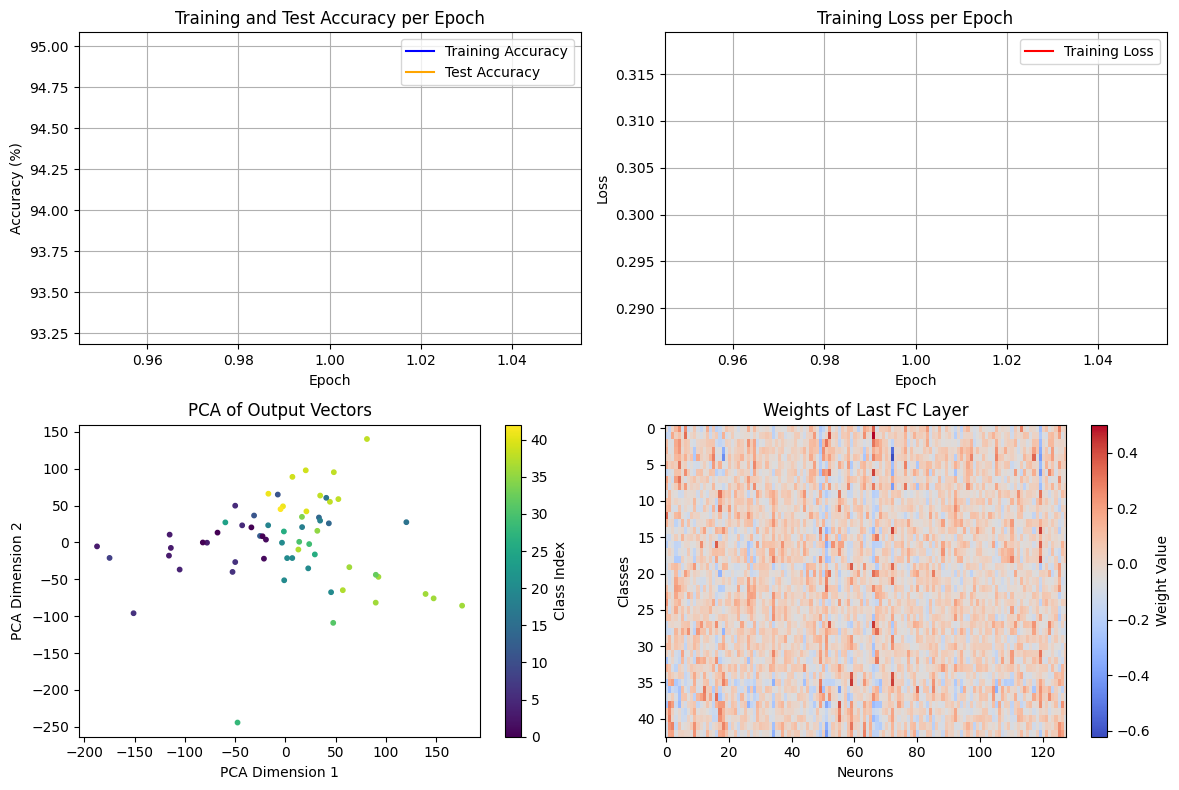

Epoch 2/10
Training Loss: 0.2912
Training Accuracy: 95.23%
Test Accuracy: 93.79%


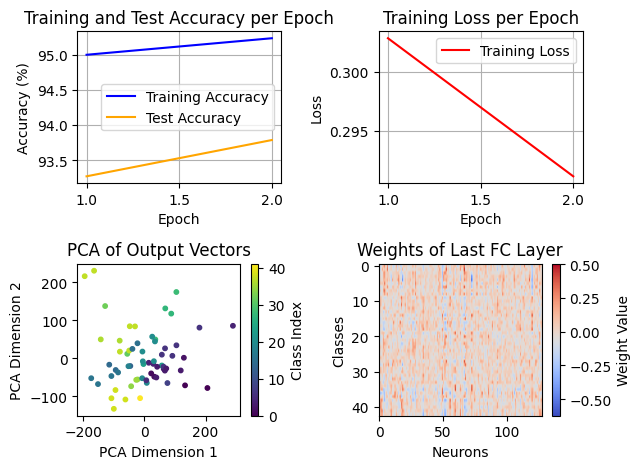

Epoch 3/10
Training Loss: 0.2675
Training Accuracy: 95.32%
Test Accuracy: 94.28%


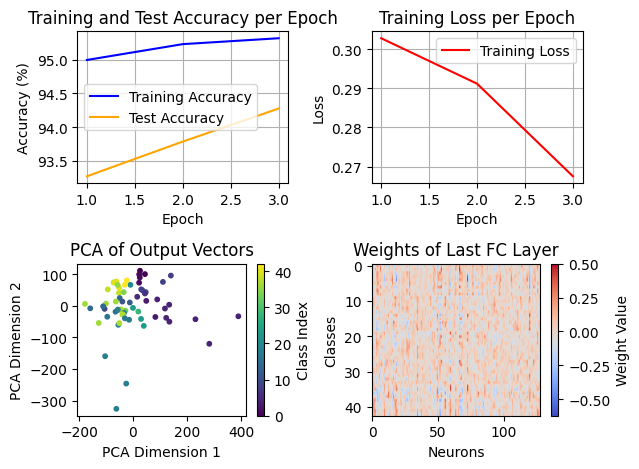

Epoch 4/10
Training Loss: 0.2652
Training Accuracy: 95.19%
Test Accuracy: 93.32%


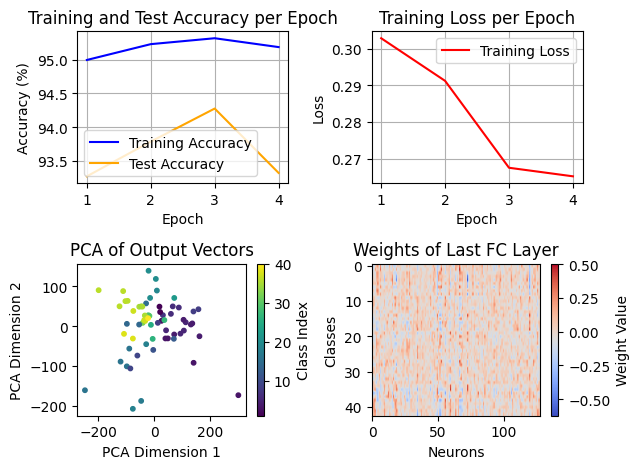

Epoch 5/10
Training Loss: 0.2530
Training Accuracy: 96.22%
Test Accuracy: 94.77%


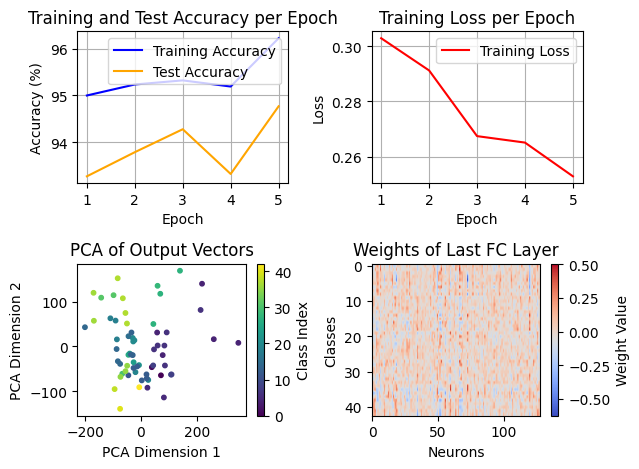

Epoch 6/10
Training Loss: 0.2417
Training Accuracy: 95.77%
Test Accuracy: 94.68%


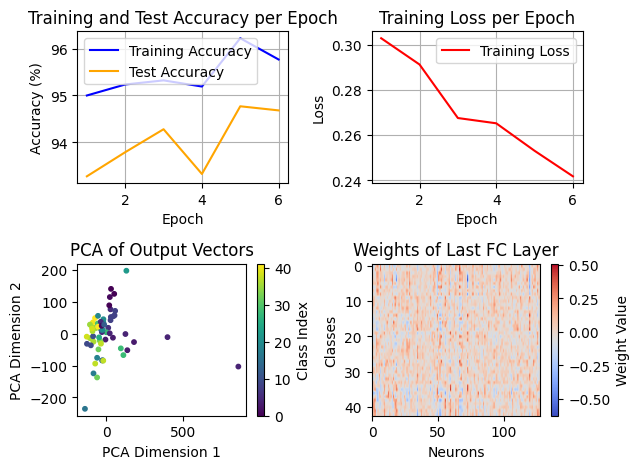

Epoch 7/10
Training Loss: 0.2396
Training Accuracy: 95.55%
Test Accuracy: 94.31%


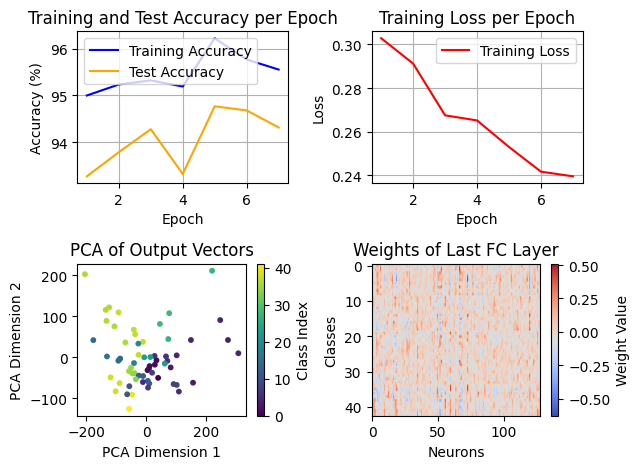

Epoch 8/10
Training Loss: 0.2304
Training Accuracy: 96.64%
Test Accuracy: 93.52%


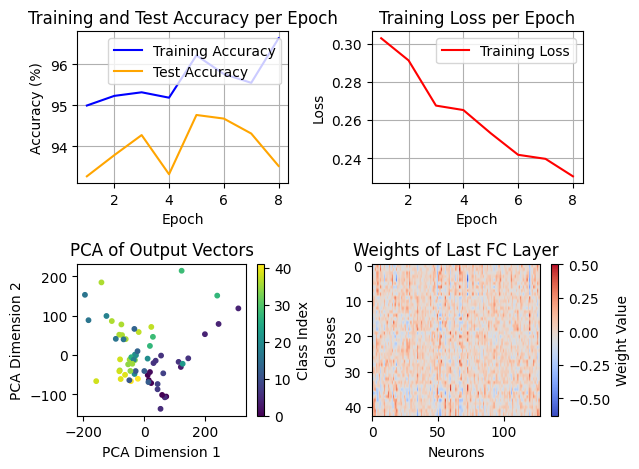

Epoch 9/10
Training Loss: 0.2072
Training Accuracy: 96.52%
Test Accuracy: 94.93%


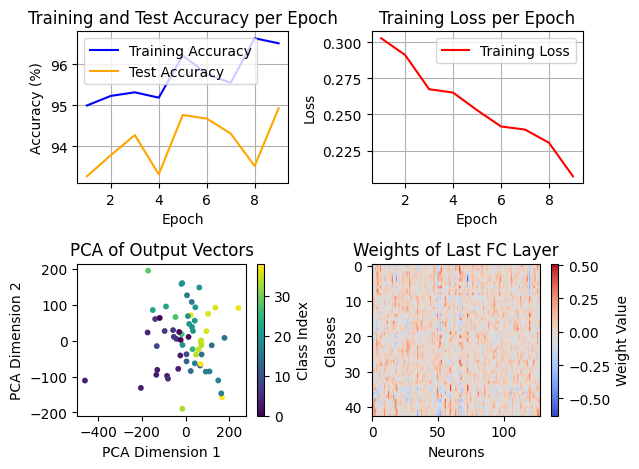

Epoch 10/10
Training Loss: 0.2098
Training Accuracy: 96.97%
Test Accuracy: 95.03%


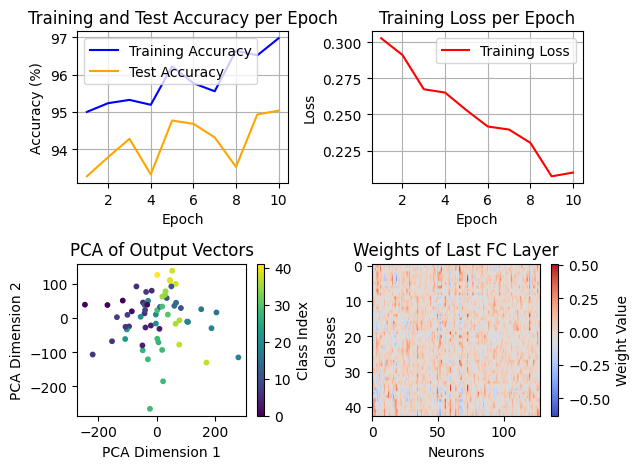

In [125]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import torch

# Zusätzliche Listen für neue Visualisierungen
last_layer_weights = []
tsne_results = []

num_epochs = 100
train_accuracies = []
test_accuracies = []
train_losses = []

# Initialize the plots
plt.figure(figsize=(12, 8))

# Variable für Loader-Wechsel
current_loader = train_loader
previous_loss = float('inf')
switch_epoch = None  # Speichert die Epoche des Loaderswechsels

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    model.train()
    running_loss = 0.0  # Track the loss for the current epoch

    for i, (images, labels) in enumerate(current_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(images)  # Forward pass
        loss = loss_func(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        running_loss += loss.item()  # Accumulate loss

    # Calculate average loss for the current epoch
    avg_loss = running_loss / len(current_loader)

    # Accuracy on training and test data
    train_accuracy = calculate_accuracy(model, current_loader, device)
    test_accuracy = calculate_accuracy(model, test_loader, device)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    train_losses.append(avg_loss)

    print(f"Training Loss: {avg_loss:.4f}")
    print(f"Training Accuracy: {train_accuracy:.2f}%")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    # Check if loss has increased and Loader hasn't switched yet
    if avg_loss > previous_loss and current_loader == train_loader:
        print("Loss has increased. Switching to train_transforms_loader.")
        current_loader = train_transforms_loader  # Wechsel zu transformiertem Loader
        switch_epoch = epoch  # Speichere die Epoche des Wechsels
        print("Training will continue for exactly 10 epochs after loader switch.")

    # Update the previous loss
    previous_loss = avg_loss

    # Visualisierung der Gewichte der letzten Schicht (vor dem Output Layer)
    last_fc_weights = model.fc9.weight.data.cpu().numpy()  # Anpassen, falls die Schicht anders heißt
    last_layer_weights.append(last_fc_weights)

    # t-SNE auf die Output-Vektoren anwenden
    with torch.no_grad():
        tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
        outputs_2d = tsne.fit_transform(outputs.cpu().numpy())
    tsne_results.append(outputs_2d)

    # Visualisierungen aktualisieren
    plt.clf()  # Clear the figure
    plt.figure(figsize=(12, 8))
    # Plot 1: Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(range(1, epoch + 2), train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(range(1, epoch + 2), test_accuracies, label='Test Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Test Accuracy per Epoch')
    plt.legend()
    plt.grid(True)

    # Plot 2: Loss
    plt.subplot(2, 2, 2)
    plt.plot(range(1, epoch + 2), train_losses, label='Training Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss per Epoch')
    plt.legend()
    plt.grid(True)

    # Plot 3: t-SNE der Outputs
    plt.subplot(2, 2, 3)
    plt.scatter(outputs_2d[:, 0], outputs_2d[:, 1], c=labels.cpu().numpy(), cmap='viridis', s=10)
    plt.colorbar(label='Class Index')
    plt.title('t-SNE of Output Vectors')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')

    # Plot 4: Visualisierung der letzten Layer-Gewichte
    plt.subplot(2, 2, 4)
    plt.imshow(last_fc_weights, cmap='coolwarm', aspect='auto')
    plt.colorbar(label='Weight Value')
    plt.title('Weights of Last FC Layer')
    plt.xlabel('Neurons')
    plt.ylabel('Classes')

    if switch_epoch is not None and epoch >= switch_epoch + 10:
        print(f"Stopping training after 10 epochs post-switch at epoch {epoch + 1}.")
        plt.savefig(f'model/optim_loop/RMSprop/train_{train_accuracy}_test_{test_accuracy}.png')
        break

    # Display the updated plot
    plt.tight_layout()
    plt.pause(0.1)

# Save the model's weights
torch.save(model.state_dict(), f'model/gute_modell.pth')
torch.save(model.state_dict(), f'model/optim_loop/RMSprop/train_{train_accuracy}_test_{test_accuracy}.pth')

# Show the final plot after all epochs
plt.show()


### Train Code from yt 
(https://www.youtube.com/watch?v=ZBfpkepdZlw)

In [ ]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
		# load in the data in batches
    for i, (images, labels) in enumerate(train_loader):  
        # move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # forward propagation
        outputs = model(images)
        loss = loss_func(outputs, labels)
        
        # backward propagation and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # at end of epoch check validation loss and acc
    with torch.no_grad():
      	# switch model to eval (not train) model
        model.eval()
        correct = 0
        total = 0
        all_val_loss = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            total += labels.size(0)
            # calculate predictions
            predicted = torch.argmax(outputs, dim=1)
            # calculate actual values
            correct += (predicted == labels).sum().item()
            # calculate the loss
            all_val_loss.append(loss_func(outputs, labels).item())
        # calculate val-loss
        mean_val_loss = sum(all_val_loss) / len(all_val_loss)
        # calculate val-accuracy
        mean_val_acc = 100 * (correct / total)
    print(
        'Epoch [{}/{}], Loss: {:.4f}, Val-loss: {:.4f}, Val-acc: {:.1f}%'.format(
            epoch+1, num_epochs, loss.item(), mean_val_loss, mean_val_acc
        )
    )

# Test the Model

### Test the current Model

In [ ]:
def calculate_accuracy(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # No gradient computation
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the same device as the model
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the index of the maximum value in the output
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

# Determine the device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the same device
model.to(device)
# Calculate accuracy on training data
train_accuracy = calculate_accuracy(model, train_loader, device)
print(f"Accuracy on training data: {train_accuracy:.2f}%")

# Calculate accuracy on test data
test_accuracy = calculate_accuracy(model, test_loader, device)
print(f"Accuracy on test data: {test_accuracy:.2f}%")

#torch.save(model.state_dict(), "model/good_models/99_95_and_95_77/training_99_95_test_95_77.pth")


### Calculate Accuracy per Class

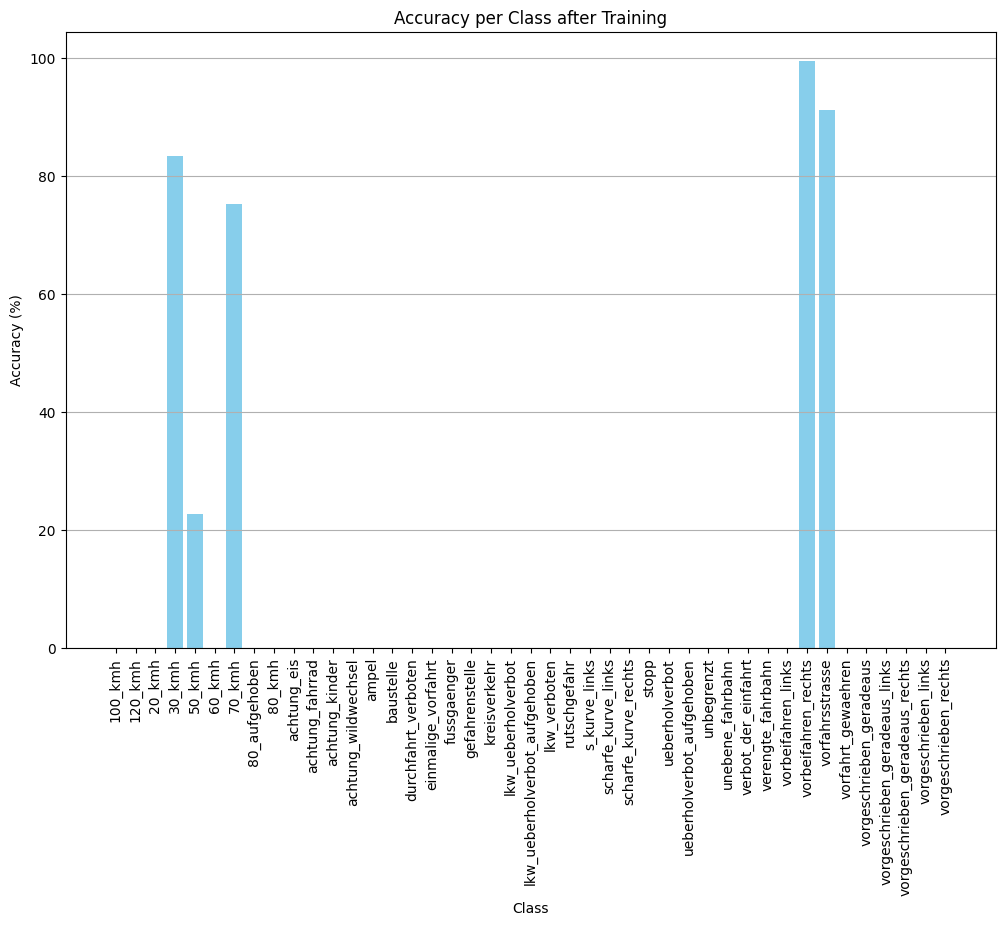

In [88]:
import torch
import matplotlib.pyplot as plt

# Berechnet die Accuracy pro Klasse, ohne die Anzahl der Klassen als Eingabe zu benötigen
def calculate_class_accuracy(model, data_loader, device):
    model.eval()
    
    # Hole die Anzahl der Klassen und die Klassennamen aus dem Dataset
    class_names = data_loader.dataset.classes
    num_classes = len(class_names)
    
    class_correct = [0] * num_classes
    class_total = [0] * num_classes
    
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            # Sammle die Richtigkeit der Vorhersagen für jede Klasse
            for i in range(len(labels)):
                label = labels[i].item()
                class_total[label] += 1
                if predicted[i] == labels[i]:
                    class_correct[label] += 1
    
    # Berechne die Accuracy für jede Klasse
    class_accuracy = [100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]
    return class_accuracy, class_names

# Berechne und plotte die Klassenaccuracy nach den 40 Trainingsepochen
class_accuracies, class_names = calculate_class_accuracy(trained_model, test_loader, device)

# Plot Histogramm der Klassenaccuracies mit Klassennamen auf der x-Achse
plt.figure(figsize=(12, 8))
plt.bar(range(len(class_names)), class_accuracies, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Class after Training')
plt.xticks(range(len(class_names)), class_names, rotation=90)  # Setzt die Klassennamen als x-Achsen-Beschriftungen
plt.grid(axis='y')
plt.show()


### Calculate Accuracy per Class and save wrong Predictions

In [ ]:
import torch
import matplotlib.pyplot as plt
from collections import defaultdict

# Berechnet die Accuracy pro Klasse und speichert falsche Vorhersagen
def calculate_class_accuracy_and_misclassifications(model, data_loader, device):
    model.eval()
    
    # Hole die Anzahl der Klassen und die Klassennamen aus dem Dataset
    class_names = data_loader.dataset.classes
    num_classes = len(class_names)
    
    class_correct = [0] * num_classes
    class_total = [0] * num_classes
    misclassified_counts = defaultdict(lambda: [0] * num_classes)  # Zählt Fehlklassifizierungen je Klasse
    
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            # Zählt korrekte und fehlerhafte Vorhersagen
            for i in range(len(labels)):
                label = labels[i].item()
                class_total[label] += 1
                if predicted[i] == labels[i]:
                    class_correct[label] += 1
                else:
                    misclassified_counts[label][predicted[i].item()] += 1  # Fehlklassifizierung speichern
    
    # Berechne die Accuracy für jede Klasse
    class_accuracy = [100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]
    return class_accuracy, class_names, misclassified_counts

# Berechne Accuracy und Fehlklassifizierungen
class_accuracies, class_names, misclassified_counts = calculate_class_accuracy_and_misclassifications(trained_model, test_loader, device)

# Erstelle Plots für Klassen mit einer Accuracy < 80%
for i, accuracy in enumerate(class_accuracies):
    if accuracy < 80:
        # Bereite Daten für die Fehlklassifizierungen dieser Klasse auf
        misclassified_counts_for_class = misclassified_counts[i]
        misclassified_class_names = [class_names[j] for j in range(len(misclassified_counts_for_class)) if misclassified_counts_for_class[j] > 0]
        misclassified_class_counts = [misclassified_counts_for_class[j] for j in range(len(misclassified_counts_for_class)) if misclassified_counts_for_class[j] > 0]
        
        # Plot der Fehlklassifizierungen für die Klasse
        plt.figure(figsize=(8, 5))
        plt.bar(misclassified_class_names, misclassified_class_counts, color='salmon')
        plt.xlabel('Predicted Class')
        plt.ylabel('Count')
        plt.title(f"Misclassifications for Class '{class_names[i]}' (Accuracy: {accuracy:.2f}%)")
        plt.xticks(rotation=90)
        plt.grid(axis='y')
        plt.show()


### If you want to test an old model, you can do this right here

Define the CNN Model Class vor Evaluation. Make sure you replace this with the correct Conv Layers and FC Layers of your trained model. 

In [6]:
class Net(nn.Module):
    def __init__(self, num_classes, image_size = 35):
        super(Net, self).__init__()
        # Convolutional Layers
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, padding=1)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_layer2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=4, padding=1)
        self.relu2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_layer3 = nn.Conv2d(in_channels=192, out_channels=384, kernel_size=4, padding=1)
        self.relu3 = nn.ReLU()

        self.conv_layer4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=4, padding=1)
        self.relu4 = nn.ReLU()

        self.conv_layer5 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=4, padding=1)
        self.relu5 = nn.ReLU()
        self.max_pool5 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.dropout6 = nn.Dropout(p=0.5)

        # Dynamische Berechnung der FC-Eingabegröße
        self.flatten = nn.Flatten()
        dummy_input = torch.zeros(batch_size, 3, image_size, image_size)  # Dummy-Eingabe mit typischer Größe (z.B. 224x224)
        fc_input_size = self._get_fc_input_size(dummy_input)

        # Fully Connected Layers
        self.fc6 = nn.Linear(fc_input_size, 512)
        self.relu6 = nn.ReLU()
        self.dropout7 = nn.Dropout(p=0.5)
        self.fc7 = nn.Linear(512, 256)
        self.relu7 = nn.ReLU()

        self.dropout8 = nn.Dropout(p=0.5)
        self.fc8 = nn.Linear(256, 128)
        self.relu8 = nn.ReLU()

        self.fc9 = nn.Linear(128, num_classes)

    def _get_fc_input_size(self, dummy_input):
        """Hilfsfunktion, um die Eingabegröße für die Fully Connected Layers zu berechnen."""
        with torch.no_grad():
            x = self.conv_layer1(dummy_input)
            x = self.relu1(x)
            x = self.max_pool1(x)

            x = self.conv_layer2(x)
            x = self.relu2(x)
            x = self.max_pool2(x)

            x = self.conv_layer3(x)
            x = self.relu3(x)

            x = self.conv_layer4(x)
            x = self.relu4(x)

            x = self.conv_layer5(x)
            x = self.relu5(x)
            x = self.max_pool5(x)

            x = self.flatten(x)  # Flatten the output
        return x.size(1)  # Gib die Anzahl der Features zurück

    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.relu1(out)
        out = self.max_pool1(out)

        out = self.conv_layer2(out)
        out = self.relu2(out)
        out = self.max_pool2(out)

        out = self.conv_layer3(out)
        out = self.relu3(out)

        out = self.conv_layer4(out)
        out = self.relu4(out)

        out = self.conv_layer5(out)
        out = self.relu5(out)
        out = self.max_pool5(out)

        out = self.flatten(out)  # Flatten
        out = self.dropout6(out)
        out = self.fc6(out)
        out = self.relu6(out)

        out = self.dropout7(out)
        out = self.fc7(out)
        out = self.relu7(out)

        out = self.dropout8(out)
        out = self.fc8(out)
        out = self.relu8(out)

        out = self.fc9(out)

        return out


Provide now informations such as path and the number of output classes

In [105]:
import torch
import os
from torchvision import transforms
from PIL import Image

# Bildpfad angeben
image_path = 'GTSRB\Final_Test\Images\stopp\\00093.ppm'  # Hier den Pfad zum Bild angeben

# Prüfen, ob der Modellpfad existiert
model_path = 'model/FINAL_Models/Adagrad_FINAL_image_size_35_train_84.71779438394246_test_90.04906277519184.pth'
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Das Modell unter '{model_path}' wurde nicht gefunden.")

# Dictionary für die Aktivierungen
activations = {}

# Hook-Funktion, um die Ausgaben zu speichern
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Initialisierung des Modells
trained_model = Net(num_classes=43)
trained_model.to(device)

# Modell laden
trained_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# Hooks für die Schichten des Modells registrieren
trained_model.conv_layer1.register_forward_hook(get_activation('conv_layer1'))
trained_model.conv_layer2.register_forward_hook(get_activation('conv_layer2'))
trained_model.conv_layer3.register_forward_hook(get_activation('conv_layer3'))
trained_model.conv_layer4.register_forward_hook(get_activation('conv_layer4'))
trained_model.conv_layer5.register_forward_hook(get_activation('conv_layer5'))

# Hooks für die ReLU-Schichten registrieren
trained_model.relu1.register_forward_hook(get_activation('relu1'))
trained_model.relu2.register_forward_hook(get_activation('relu2'))
trained_model.relu3.register_forward_hook(get_activation('relu3'))
trained_model.relu4.register_forward_hook(get_activation('relu4'))
trained_model.relu5.register_forward_hook(get_activation('relu5'))

# Hooks für Fully-Connected-Schichten registrieren
trained_model.fc6.register_forward_hook(get_activation('fc6'))
trained_model.fc7.register_forward_hook(get_activation('fc7'))
trained_model.fc8.register_forward_hook(get_activation('fc8'))
trained_model.fc9.register_forward_hook(get_activation('fc9'))

# Hooks für ReLU in Fully-Connected-Schichten registrieren
trained_model.relu6.register_forward_hook(get_activation('relu6'))
trained_model.relu7.register_forward_hook(get_activation('relu7'))
trained_model.relu8.register_forward_hook(get_activation('relu8'))

# Bildvorverarbeitung definieren
transform = transforms.Compose([
    transforms.Resize((35, 35)),  # Größe anpassen
    transforms.ToTensor(),       # In Tensor umwandeln
    transforms.Normalize(mean=mean, std=std)  # Normalisierung
])

# Test Forward-Pass mit Bild
if __name__ == "__main__":
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Das Bild unter '{image_path}' wurde nicht gefunden.")
    
    # Bild laden und vorverarbeiten
    image = Image.open(image_path).convert('RGB')  # Bild in RGB umwandeln
    image = transform(image).unsqueeze(0)         # Batch-Dimension hinzufügen
    
    # Bild durch das Modell leiten
    image = image.to(device)
    output = trained_model(image)
    
    print("Forward-Pass abgeschlossen.")
    print("Gespeicherte Aktivierungen:", activations.keys())


Forward-Pass abgeschlossen.
Gespeicherte Aktivierungen: dict_keys(['conv_layer1', 'relu1', 'conv_layer2', 'relu2', 'conv_layer3', 'relu3', 'conv_layer4', 'relu4', 'conv_layer5', 'relu5', 'fc6', 'relu6', 'fc7', 'relu7', 'fc8', 'relu8', 'fc9'])


C:\Users\v814u63\AppData\Local\Temp\ipykernel_21952\3316402853.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load(model_path, map_

Now you can test your new model

In [29]:
def calculate_accuracy(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # No gradient computation
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the same device as the model
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the index of the maximum value in the output
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

# Determine the device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the same device
trained_model.to(device)
# Calculate accuracy on training data
train_accuracy = calculate_accuracy(trained_model, train_loader, device)
print(f"Accuracy on training data: {train_accuracy:.2f}%")

# Calculate accuracy on test data
test_accuracy = calculate_accuracy(trained_model, test_loader, device)
print(f"Accuracy on test data: {test_accuracy:.2f}%")

Accuracy on training data: 99.70%
Accuracy on test data: 97.06%


# Visualisation and Explainable Part 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6596274..3.716739].


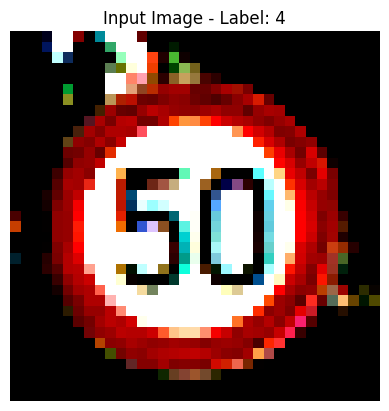

In [30]:
# Get a batch of test images
images, labels = next(iter(test_loader))

# Select a random or specific image by changing the index
rand = 9  # Ändere die Zahl hier, um ein anderes Bild anzuzeigen
image = images[rand:rand+1]
label = labels[rand]
image = image.to(device)
label = label.to(device)

# Display the input image
plt.imshow(image[0].permute(1, 2, 0).cpu())  # Bild vom Tensor in NumPy-Format umwandeln
plt.title(f'Input Image - Label: {label.item()}')
plt.axis('off')
plt.show()


In [31]:
# Eingabebild (Beispiel)
image = torch.randn(1, 3, 35, 35).to(device)  # Simuliertes Bild (Batch-Größe 1)

# Reset des Aktivierungs-Dictionaries
activations = {}

# Forward-Pass
output = trained_model(image)

# Gespeicherte Aktivierungen ausgeben
print("Gespeicherte Aktivierungen:", activations.keys())
for layer, activation in activations.items():
    print(f"{layer}: {activation.shape}")

{'conv_layer1': tensor([[[[ 0.3754,  0.6226,  0.1182,  ...,  0.5933,  0.7147,  0.5334],
          [ 0.2318,  0.7272,  0.3491,  ...,  0.6855,  0.7609,  0.6946],
          [ 0.2285,  0.6162,  0.5535,  ...,  0.7020,  0.5336,  0.6316],
          ...,
          [ 0.1071,  0.4166,  0.5872,  ...,  0.6064,  0.5480,  0.6299],
          [-0.0295,  0.5350,  0.6374,  ...,  0.6171,  0.5743,  0.6927],
          [ 0.3133,  0.6879,  0.6786,  ...,  0.6660,  0.6601,  0.4837]],

         [[-0.2685, -0.5890,  0.0238,  ..., -0.6085, -0.6042, -0.5767],
          [-0.6996, -0.9424, -0.0093,  ..., -1.1702, -1.0931, -1.0069],
          [-0.7191, -0.9099, -0.3041,  ..., -1.1193, -1.0547, -0.9472],
          ...,
          [-0.8718, -1.0994, -1.1063,  ..., -1.0266, -1.0666, -0.9972],
          [-0.7422, -0.8146, -1.0478,  ..., -1.0757, -1.0654, -0.9865],
          [-0.8384, -1.1575, -1.3264,  ..., -1.3231, -1.3017, -1.1447]],

         [[-0.1097, -0.1183, -0.3460,  ..., -0.0783, -0.0635, -0.3702],
          [-0.

Shape of conv1 activations: torch.Size([1, 64, 34, 34])


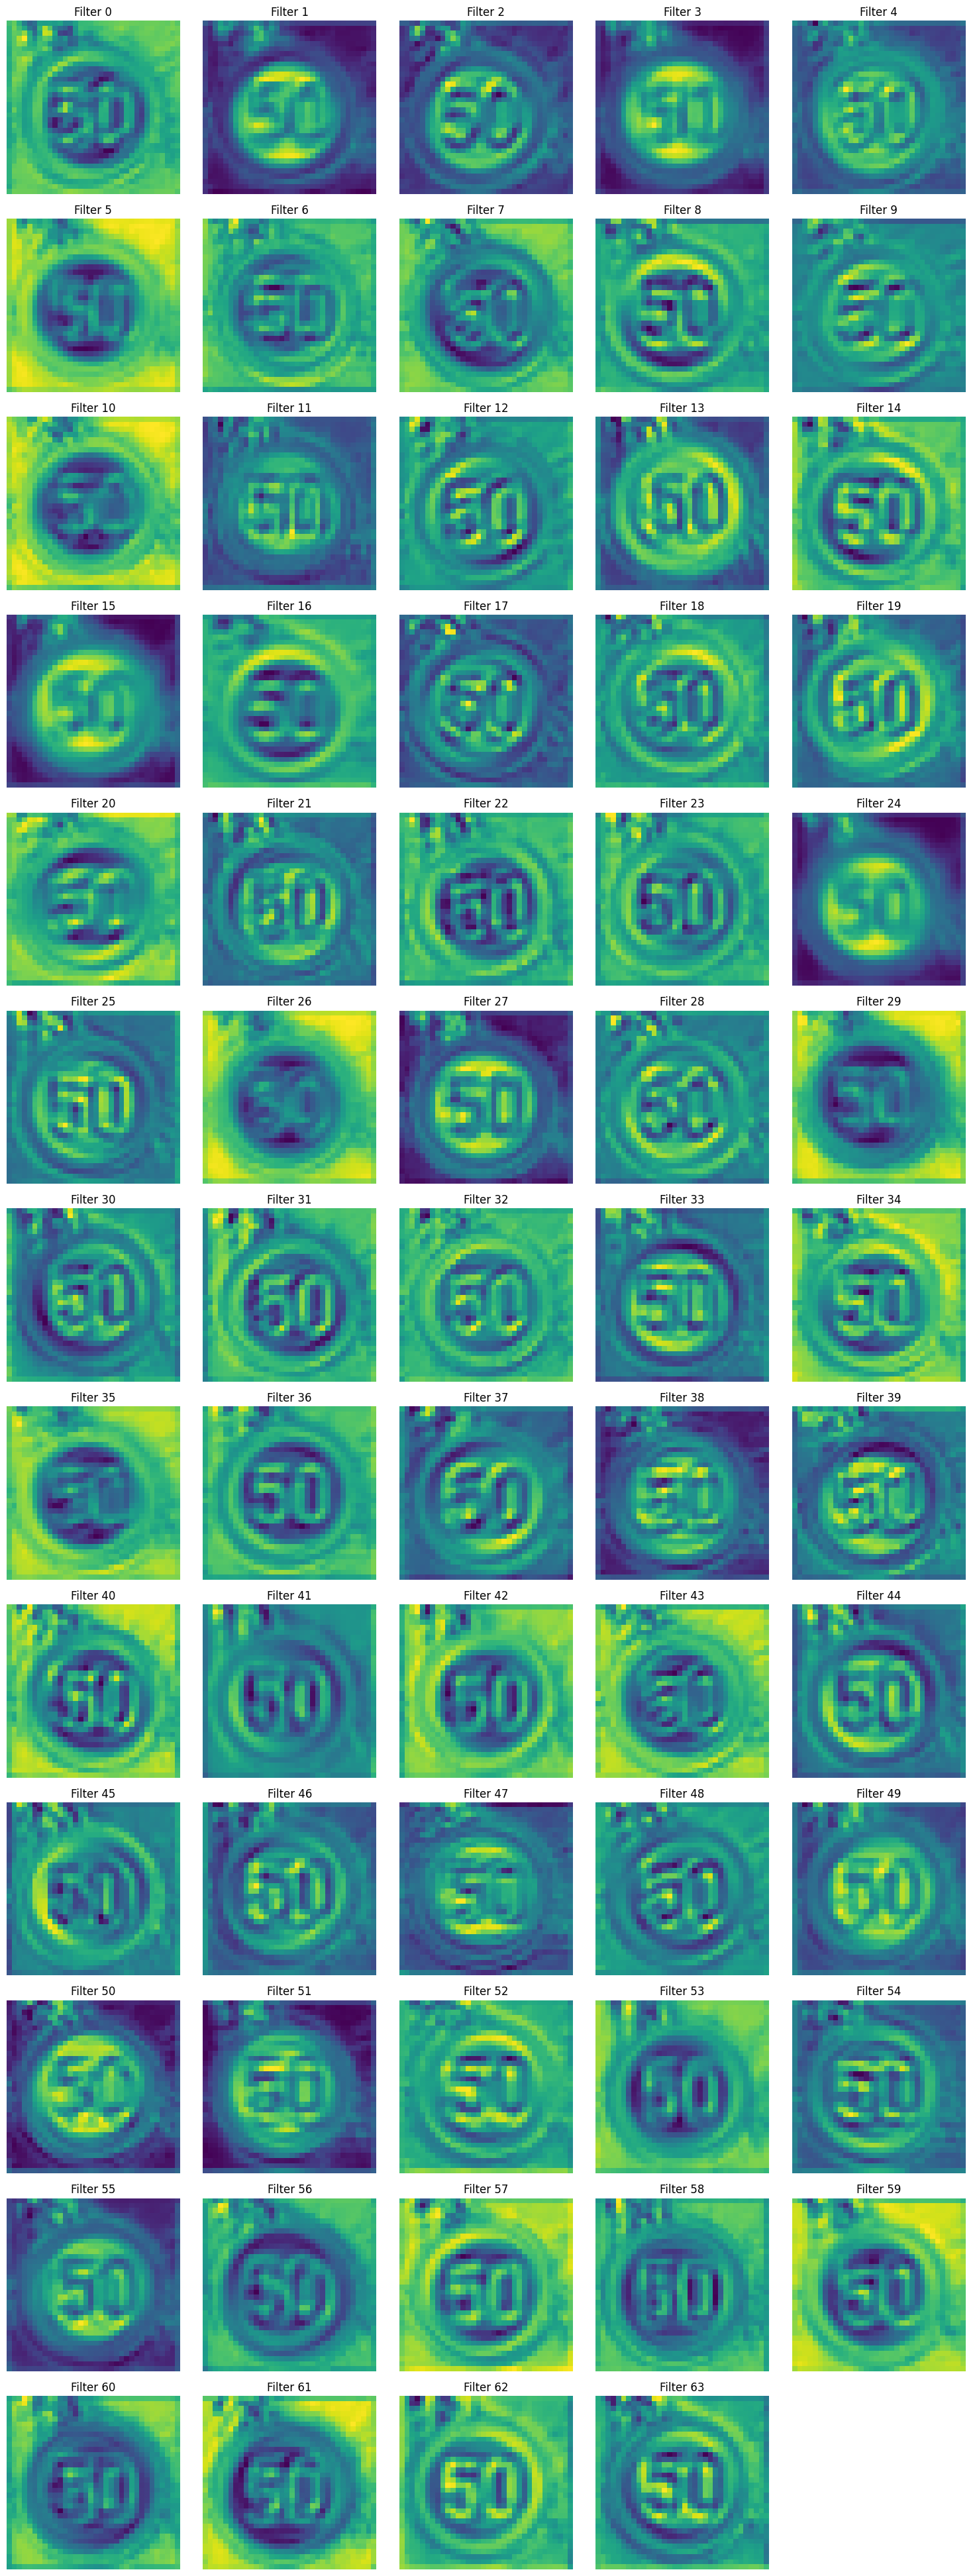

In [32]:
import math
import matplotlib.pyplot as plt

# Aktivierungen abrufen
act = activations['conv_layer1']
print(f"Shape of conv1 activations: {act.shape}")

# Filter-Anzahl
num_filters = act.shape[1]

# Dynamische Subplots
rows = math.ceil(num_filters / 5)
fig, axes = plt.subplots(rows, 5, figsize=(15, rows * 3))

for idx in range(num_filters):
    row = idx // 5
    col = idx % 5
    axes[row, col].imshow(act[0, idx].detach().cpu(), cmap='viridis')
    axes[row, col].axis('off')
    axes[row, col].set_title(f'Filter {idx}')

# Unbenutzte Subplots entfernen (falls nötig)
for idx in range(num_filters, rows * 5):
    row = idx // 5
    col = idx % 5
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


### Activation Maximazation

In [102]:
def activation_maximization(model, layer_name, filter_index, input_size=(1, 3, 35, 35), lr=0.1, iterations=30):
    device = next(model.parameters()).device  # Gerät des Modells (CPU oder GPU)
    
    # Initialisierung der Eingabe
    input_image = torch.randn(input_size, requires_grad=True, device=device)  # Auf das richtige Gerät legen
    
    optimizer = optim.Adagrad([input_image], lr=lr, weight_decay=1e-6)
    activations = {}

    # Hook-Funktion für die gewünschte Schicht
    def hook_function(module, input, output):
        activations[layer_name] = output

    # Hook registrieren
    layer = dict(model.named_modules())[layer_name]
    hook = layer.register_forward_hook(hook_function)

    for i in range(iterations):
        optimizer.zero_grad()
        model(input_image)  # Modell auf dem richtigen Gerät ausführen
        act = activations[layer_name][0, filter_index]
        loss = -torch.mean(act)  # Aktivierung maximieren
        loss.backward()
        optimizer.step()
        # Eingabewerte beschränken
        input_image.data = torch.clamp(input_image.data, 0, 1)
        # if (i + 1) % 10 == 0:
        #     print(f"Iteration {i+1}/{iterations}, Loss: {-loss.item():.4f}")

    hook.remove()
    return input_image.detach()


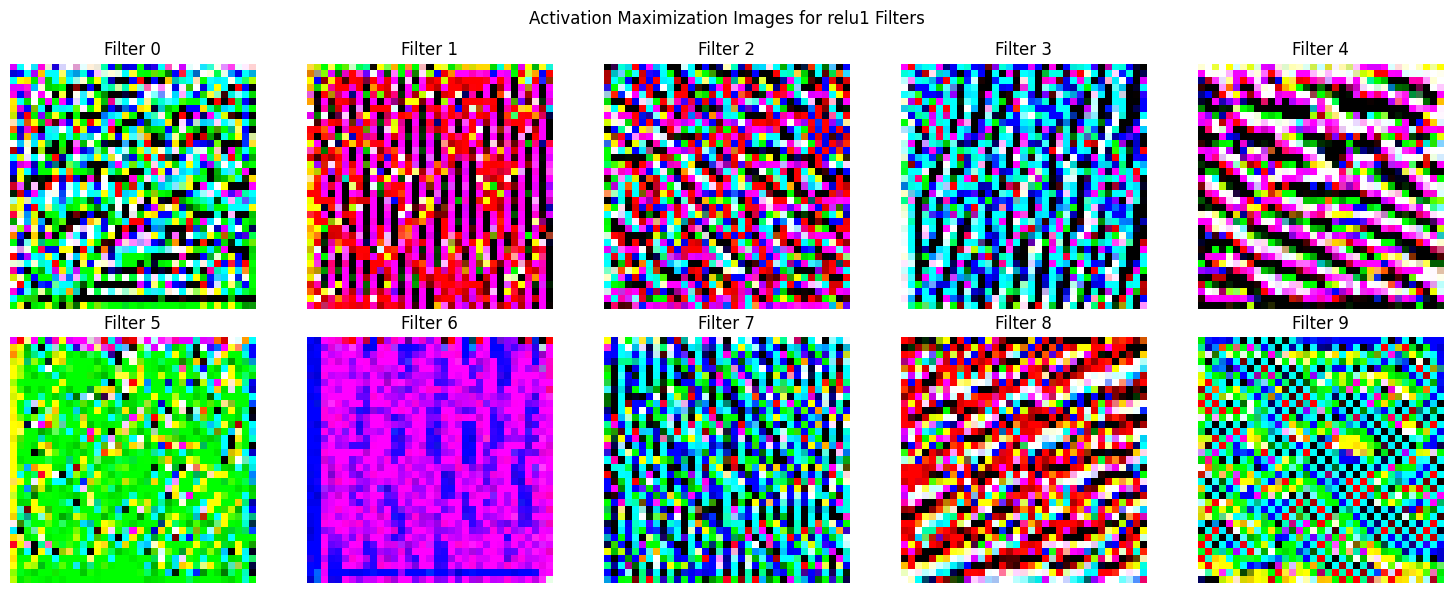

In [103]:
conv_layer1num_filters_relu1 = trained_model.conv_layer1.out_channels
am_images_relu1 = []

for filter_idx in range(conv_layer1num_filters_relu1):
    #print(f"\nGenerating image for relu1 filter {filter_idx}")
    am_image = activation_maximization(trained_model, 'relu1', filter_idx, input_size=(1, 3, 35, 35), lr=0.1, iterations=30)
    am_images_relu1.append(am_image)

#print("\nCompleted activation maximization for relu1.")

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for idx, am_image in enumerate(am_images_relu1[:10]):  # Maximal 10 Bilder anzeigen
    row = idx // 5
    col = idx % 5
    axes[row, col].imshow(am_image.squeeze().permute(1, 2, 0).cpu().numpy())  # RGB-Bild darstellen
    axes[row, col].axis('off')
    axes[row, col].set_title(f'Filter {idx}')

plt.suptitle('Activation Maximization Images for relu1 Filters')
plt.tight_layout()
plt.show()



Completed activation maximization for relu2.


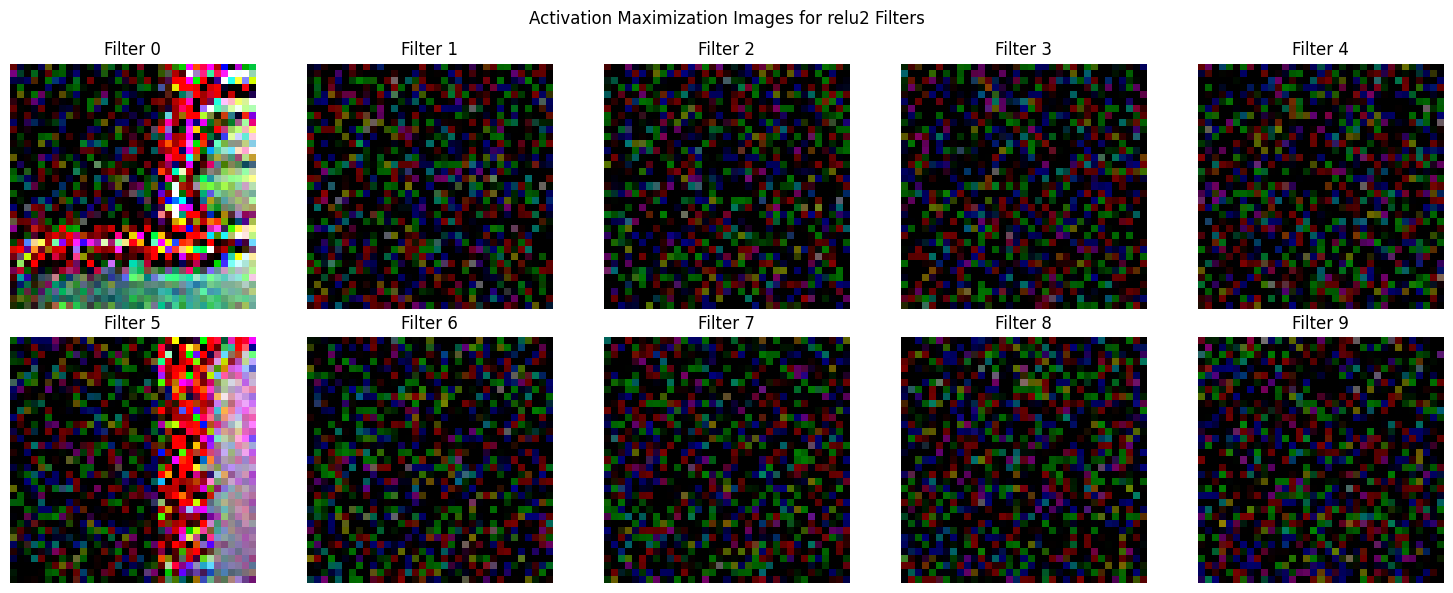

In [104]:
# ReLu 2

# Anzahl der Filter in der zweiten Schicht (ReLU2)
conv_layer2num_filters_relu2 = trained_model.conv_layer2.out_channels
am_images_relu2 = []

# Aktivierungsmaximierung für alle Filter der ReLU2-Schicht
for filter_idx in range(conv_layer2num_filters_relu2):
    #print(f"\nGenerating image for relu2 filter {filter_idx}")
    am_image = activation_maximization(
        trained_model, 'relu2', filter_idx, input_size=(1, 3, 35, 35), lr=0.1, iterations=30
    )
    am_images_relu2.append(am_image)

print("\nCompleted activation maximization for relu2.")

# Darstellung der Ergebnisse
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # Layout für 10 Filter

for idx, am_image in enumerate(am_images_relu2[:10]):  # Maximal 10 Bilder anzeigen
    row = idx // 5
    col = idx % 5
    axes[row, col].imshow(am_image.squeeze().permute(1, 2, 0).cpu().numpy())  # RGB-Bild
    axes[row, col].axis('off')
    axes[row, col].set_title(f'Filter {idx}')

plt.suptitle('Activation Maximization Images for relu2 Filters')
plt.tight_layout()
plt.show()


C:\Users\v814u63\AppData\Local\Temp\ipykernel_21952\3804530181.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load('model/FINAL_Mod

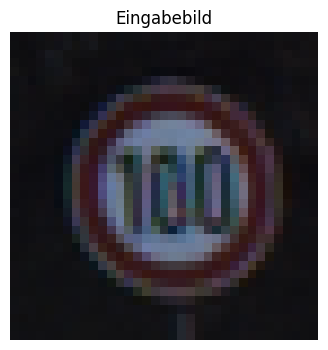

Shape der Aktivierung nach ReLU1: torch.Size([1, 64, 34, 34])
Shape von Filter 0: (34, 34)
Shape von Filter 1: (34, 34)
Shape von Filter 2: (34, 34)
Shape von Filter 3: (34, 34)
Shape von Filter 4: (34, 34)
Shape von Filter 5: (34, 34)
Shape von Filter 6: (34, 34)
Shape von Filter 7: (34, 34)
Shape von Filter 8: (34, 34)
Shape von Filter 9: (34, 34)


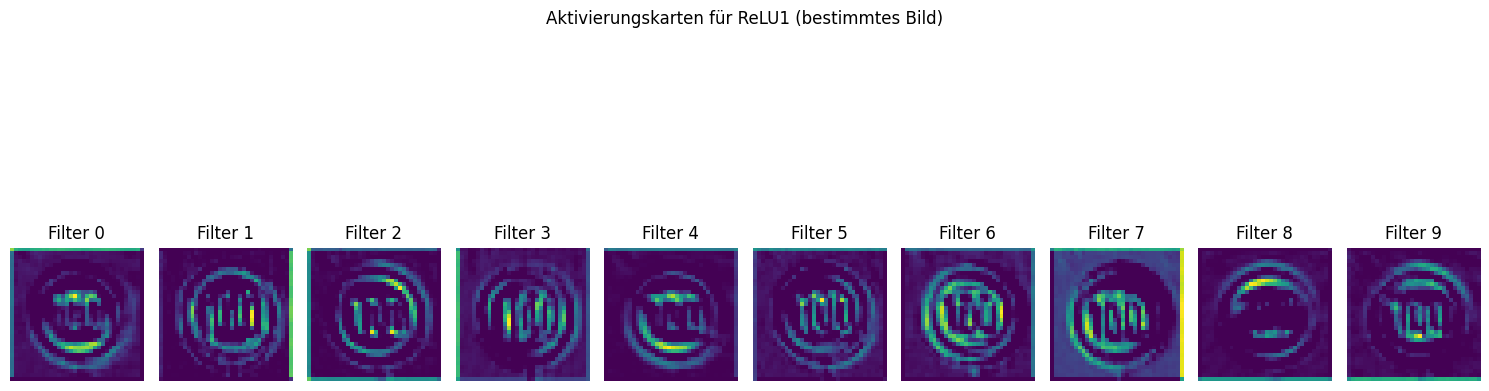

In [107]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# Pfad zum Bild
image_path = 'GTSRB\Final_Test\Images\\100_kmh\\00011.ppm'  # Bildpfad hier angeben

# Modell und Gerät (z.B. CPU oder GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Bildvorverarbeitung definieren
transform = transforms.Compose([
    transforms.Resize((35, 35)),  # Größe anpassen, z.B. 35x35
    transforms.ToTensor(),        # In Tensor umwandeln
    transforms.Normalize(mean=mean, std=std)  # Normalisierung
])

# Bild laden und vorverarbeiten
image = Image.open(image_path).convert('RGB')  # Bild in RGB umwandeln
input_image = transform(image).unsqueeze(0)  # Batch-Dimension hinzufügen

# Das Bild auf das Gerät verschieben
input_image = input_image.to(device)

# Sicherstellen, dass das Bild eine Batch-Dimension hat
# Die Variable `input_image` hat die Form (1, C, H, W)

# Modell initialisieren und laden (stellen sicher, dass es auf dem richtigen Gerät ist)
trained_model = Net(num_classes=43)  # Modell initialisieren
trained_model.to(device)  # Auf das richtige Gerät verschieben
trained_model.load_state_dict(torch.load('model/FINAL_Models/Adagrad_FINAL_image_size_35_train_84.71779438394246_test_90.04906277519184.pth', map_location=device))

# Aktivierungen für den Forward-Pass bis zur ReLU2 berechnen
with torch.no_grad():
    out_conv1 = trained_model.relu1(trained_model.conv_layer1(input_image))  # Erste Schicht + ReLU
    out_pool1 = trained_model.max_pool1(out_conv1)  # Max-Pooling
    out_conv2 = trained_model.relu2(trained_model.conv_layer2(out_pool1))  # Zweite Schicht + ReLU

# Eingabebild visualisieren
plt.figure(figsize=(4, 4))
plt.imshow(image)  # Bild im Originalformat anzeigen
plt.axis('off')
plt.title("Eingabebild")
plt.show()

# Ausgabe-Shape der Aktivierung
print("Shape der Aktivierung nach ReLU1:", out_conv1.shape)

# Aktivierungskarten der ersten 10 Filter visualisieren
num_filters = min(10, out_conv1.shape[1])  # Zeige maximal 10 Filter
fig, axes = plt.subplots(1, num_filters, figsize=(15, 6))

for i in range(num_filters):
    activation_map = out_conv1[0, i].cpu().numpy()  # Aktivierung für Filter i
    
    # Debugging: Form überprüfen
    print(f"Shape von Filter {i}: {activation_map.shape}")
    
    # Falls die Aktivierungskarten 1D sind, versuche ein Reshape
    if activation_map.ndim == 1:
        size = int(activation_map.size ** 0.5)
        assert size * size == activation_map.size, f"Aktivierung {i} hat kein quadratisches Shape!"
        activation_map = activation_map.reshape(size, size)
    
    axes[i].imshow(activation_map, cmap='viridis')
    axes[i].axis('off')
    axes[i].set_title(f'Filter {i}')

plt.suptitle("Aktivierungskarten für ReLU1 (bestimmtes Bild)")
plt.tight_layout()
plt.show()


### Grad Cam

c:\Users\v814u63\AppData\Local\anaconda3\envs\XAI\lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


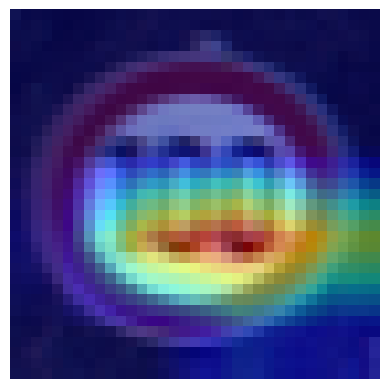

In [65]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import normalize
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F

def grad_cam(model, input_image, target_class, layer_name):
    model.eval()  

    # Dictionary to hold gradients and activations
    gradients = {}
    activations = {}

    # Hook to capture gradients
    def backward_hook(module, grad_input, grad_output):
        gradients[layer_name] = grad_output[0]

    # Hook to capture activations
    def forward_hook(module, input, output):
        activations[layer_name] = output

    # Register hooks on the desired layer
    layer = dict(model.named_modules())[layer_name]
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)

    # Forward pass
    input_image = input_image.unsqueeze(0)  # Add batch dimension
    input_image = input_image.to(next(model.parameters()).device)  # Move to device
    output = model(input_image)

    # Backward pass for the target class
    model.zero_grad()
    target_score = output[0, target_class]
    target_score.backward()

    # Compute Grad-CAM
    grads = gradients[layer_name]  # Gradients from backward pass
    acts = activations[layer_name]  # Activations from forward pass
    pooled_grads = torch.mean(grads, dim=(2, 3))  # Global average pooling

    # Weight activations by pooled gradients
    acts = acts * pooled_grads.view(1, -1, 1, 1)  # Apply broadcasting

    # Average across the channels
    heatmap = torch.mean(acts, dim=1).squeeze().detach().cpu().numpy()

    # Normalize heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap


# Visualisierung der Grad-CAM
def show_grad_cam(image, heatmap, alpha=0.5):
    # Normalize image to [0, 1]
    image = (image - image.min()) / (image.max() - image.min())

    # Resize heatmap to match image dimensions using PyTorch
    heatmap_tensor = torch.tensor(heatmap).unsqueeze(0).unsqueeze(0)  # Add batch and channel dims
    heatmap_resized = F.interpolate(heatmap_tensor, size=image.shape[:2], mode='bilinear', align_corners=False)
    heatmap_resized = heatmap_resized.squeeze().numpy()  # Remove added dims
    heatmap_resized = np.uint8(255 * heatmap_resized)  # Scale heatmap to [0, 255]

    # Convert heatmap to RGB
    heatmap_colored = plt.cm.jet(heatmap_resized)[:, :, :3]  # Convert heatmap to RGB
    heatmap_colored = heatmap_colored / np.max(heatmap_colored)  # Normalize heatmap

    # Combine heatmap with original image
    overlay = alpha * heatmap_colored + (1 - alpha) * image
    overlay = overlay / np.max(overlay)  # Normalize overlay to [0, 1]

    # Plot the result
    plt.imshow(overlay)
    plt.axis('off')
    plt.show()


# Lade und transformiere ein Bild von einem Pfad
def load_image(image_path, input_size=(3, 35, 35)):
    transform = transforms.Compose([
        transforms.Resize((input_size[1], input_size[2])),
        transforms.ToTensor()
    ])
    image = Image.open(image_path).convert("RGB")
    original_image = np.array(image) / 255.0  
    image_tensor = transform(image)
    return image_tensor, original_image


image_path = "GTSRB/Final_Test/Images/unbegrenzt/02345.ppm"  # Beispielpfad
image_tensor, original_image = load_image(image_path)

# Zielklasse und Schicht
layer_name = "conv_layer5" 
target_class = 14  

heatmap = grad_cam(trained_model, image_tensor, target_class, layer_name)
show_grad_cam(original_image, heatmap)


### LIME

100%|██████████| 1000/1000 [00:07<00:00, 131.04it/s]


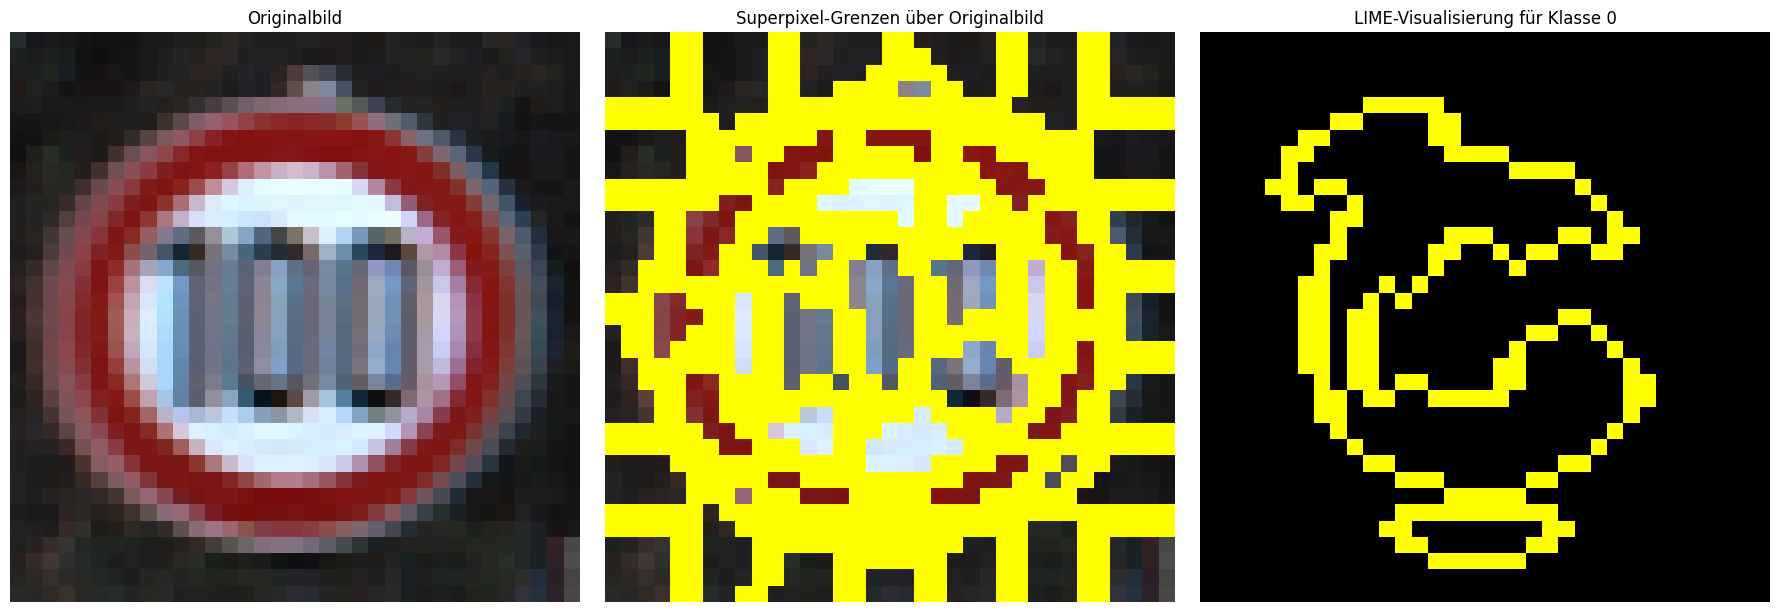

In [ ]:
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries, slic
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import numpy as np
from PIL import Image

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def transform_image_for_model(image):
    """
    Transformiert das Bild zur Modell-Eingabegröße.
    """
    transform = transforms.Compose([
        transforms.Resize((70, 70)),  # Bild bleibt bei 70x70 für LIME
    ])
    return transform(image)

def predict_proba(images):
    """
    Wrapper-Funktion für LIME, um Modellvorhersagen für eine Reihe von Bildern zu generieren.
    """
    # Transformiert Bilder zurück auf 35x35 für das Modell
    transform = transforms.Compose([
        transforms.Resize((35, 35)),
        transforms.ToTensor()
    ])
    images_tensor = torch.stack([
        transform(Image.fromarray((image * 255).astype(np.uint8))).to(device) for image in images
    ])
    with torch.no_grad():
        outputs = trained_model(images_tensor)
        probs = torch.softmax(outputs, dim=1)
    return probs.cpu().numpy()

# Initialisierung des LIME-Explainers
explainer = LimeImageExplainer()

# Bildpfad
image_path = "GTSRB/Final_Test/Images/stopp/00111.ppm" 

# Laden und Anpassen des Bildes auf 70x70 für LIME
example_image = Image.open(image_path).convert('RGB')
transformed_image = transform_image_for_model(example_image)
transformed_image_np = np.array(transformed_image) / 255.0  # Normalisierung auf [0, 1]

def custom_segmentation(image):
    """
    Angepasste Segmentierungsmethode für LIME.
    """
    return slic(image, n_segments=50, compactness=10, start_label=1)

# Generierung der LIME-Erklärung
explanation = explainer.explain_instance(
    transformed_image_np,
    predict_proba,
    top_labels=1,
    hide_color=0,
    num_samples=1000,
    segmentation_fn=custom_segmentation
)

# Visualisierung
label_to_explain = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(
    label=label_to_explain,
    positive_only=True,
    hide_rest=False,
    num_features=10,
    min_weight=0.01
)

segments = slic(transformed_image_np, n_segments=50, compactness=10, start_label=1)
boundaries_image = mark_boundaries(transformed_image_np, segments)

plt.figure(figsize=(18, 6))

# Originalbild
plt.subplot(1, 3, 1)
plt.imshow(example_image.resize((70, 70)))
plt.title("Originalbild")
plt.axis("off")

# Superpixel-Grenzen über Originalbild
plt.subplot(1, 3, 2)
plt.imshow(boundaries_image)
plt.title("Superpixel-Grenzen über Originalbild")
plt.axis("off")

# LIME-Visualisierung
plt.subplot(1, 3, 3)
plt.imshow(mark_boundaries(temp, mask))
plt.title(f"LIME-Visualisierung für Klasse {label_to_explain}")
plt.axis("off")

plt.tight_layout()
plt.show()


### Test

Step 0, Loss: -1.5198
Step 20, Loss: -138.8262
Step 40, Loss: -159.4233
Step 60, Loss: -336.1649
Step 80, Loss: -117.2092
Step 100, Loss: -369.1788
Step 120, Loss: -229.9408
Step 140, Loss: -494.0568
Step 160, Loss: -424.6750
Step 180, Loss: -103.7551


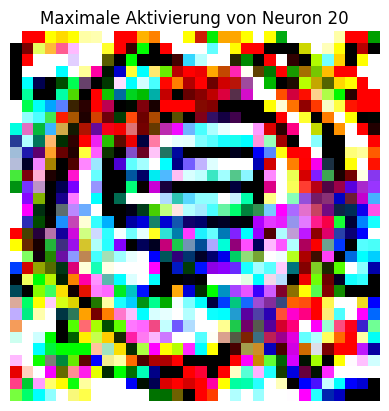

Klasse 1, Iteration 0/100, Verlust: 2.670105457305908
Klasse 1, Iteration 10/100, Verlust: -55.199703216552734
Klasse 1, Iteration 20/100, Verlust: -90.84636688232422
Klasse 1, Iteration 30/100, Verlust: -102.54561614990234
Klasse 1, Iteration 40/100, Verlust: -108.38397979736328
Klasse 1, Iteration 50/100, Verlust: -112.47578430175781
Klasse 1, Iteration 60/100, Verlust: -115.01165771484375
Klasse 1, Iteration 70/100, Verlust: -116.26347351074219
Klasse 1, Iteration 80/100, Verlust: -117.24069213867188
Klasse 1, Iteration 90/100, Verlust: -118.1073989868164


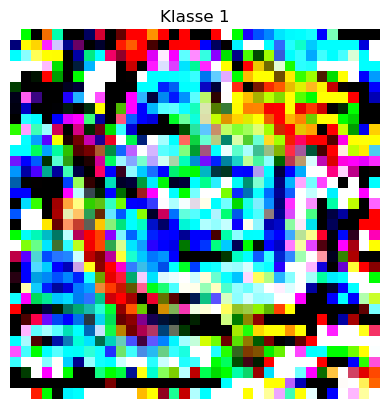

Klasse 2, Iteration 0/100, Verlust: 1.1560910940170288
Klasse 2, Iteration 10/100, Verlust: -57.67826461791992
Klasse 2, Iteration 20/100, Verlust: -86.99156951904297
Klasse 2, Iteration 30/100, Verlust: -95.93423461914062
Klasse 2, Iteration 40/100, Verlust: -100.25505828857422
Klasse 2, Iteration 50/100, Verlust: -102.58502197265625
Klasse 2, Iteration 60/100, Verlust: -104.17796325683594
Klasse 2, Iteration 70/100, Verlust: -105.2950439453125
Klasse 2, Iteration 80/100, Verlust: -106.1716079711914
Klasse 2, Iteration 90/100, Verlust: -106.97787475585938


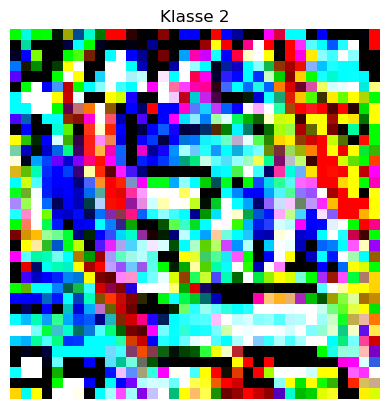

Klasse 3, Iteration 0/100, Verlust: -1.3355997800827026
Klasse 3, Iteration 10/100, Verlust: -81.31396484375
Klasse 3, Iteration 20/100, Verlust: -112.79426574707031
Klasse 3, Iteration 30/100, Verlust: -123.220703125
Klasse 3, Iteration 40/100, Verlust: -128.5223388671875
Klasse 3, Iteration 50/100, Verlust: -131.59152221679688
Klasse 3, Iteration 60/100, Verlust: -133.95248413085938
Klasse 3, Iteration 70/100, Verlust: -135.70118713378906
Klasse 3, Iteration 80/100, Verlust: -137.0547637939453
Klasse 3, Iteration 90/100, Verlust: -138.1051025390625


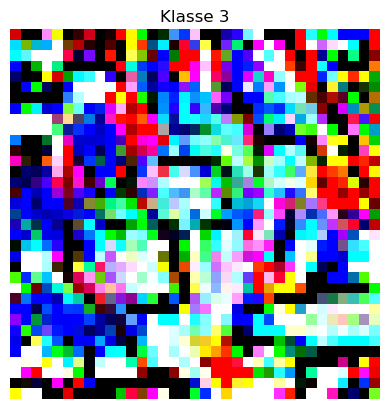

Klasse 4, Iteration 0/100, Verlust: 0.39147013425827026
Klasse 4, Iteration 10/100, Verlust: -62.96260452270508
Klasse 4, Iteration 20/100, Verlust: -117.57231903076172
Klasse 4, Iteration 30/100, Verlust: -130.13619995117188
Klasse 4, Iteration 40/100, Verlust: -135.63735961914062
Klasse 4, Iteration 50/100, Verlust: -139.03269958496094
Klasse 4, Iteration 60/100, Verlust: -140.99676513671875
Klasse 4, Iteration 70/100, Verlust: -142.02813720703125
Klasse 4, Iteration 80/100, Verlust: -142.613525390625
Klasse 4, Iteration 90/100, Verlust: -143.08290100097656


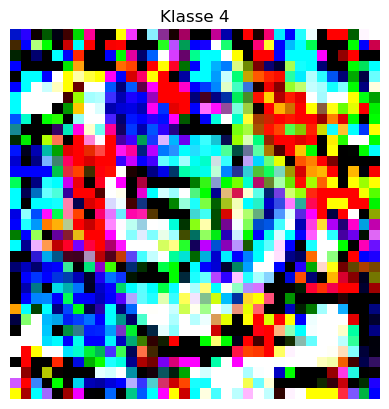

Klasse 5, Iteration 0/100, Verlust: -0.19358107447624207
Klasse 5, Iteration 10/100, Verlust: -50.34480285644531
Klasse 5, Iteration 20/100, Verlust: -81.9784927368164
Klasse 5, Iteration 30/100, Verlust: -92.47970581054688
Klasse 5, Iteration 40/100, Verlust: -97.4611587524414
Klasse 5, Iteration 50/100, Verlust: -100.15348052978516
Klasse 5, Iteration 60/100, Verlust: -102.49687194824219
Klasse 5, Iteration 70/100, Verlust: -104.32080078125
Klasse 5, Iteration 80/100, Verlust: -105.57780456542969
Klasse 5, Iteration 90/100, Verlust: -106.34671020507812


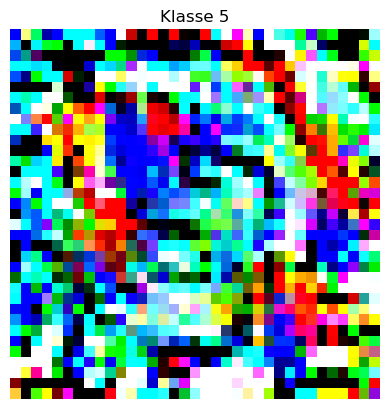

Klasse 6, Iteration 0/100, Verlust: -0.47646987438201904
Klasse 6, Iteration 10/100, Verlust: -66.9436264038086
Klasse 6, Iteration 20/100, Verlust: -104.48046112060547
Klasse 6, Iteration 30/100, Verlust: -116.39497375488281
Klasse 6, Iteration 40/100, Verlust: -121.74617004394531
Klasse 6, Iteration 50/100, Verlust: -124.73660278320312
Klasse 6, Iteration 60/100, Verlust: -126.77740478515625
Klasse 6, Iteration 70/100, Verlust: -128.3953857421875
Klasse 6, Iteration 80/100, Verlust: -129.7238006591797
Klasse 6, Iteration 90/100, Verlust: -130.92738342285156


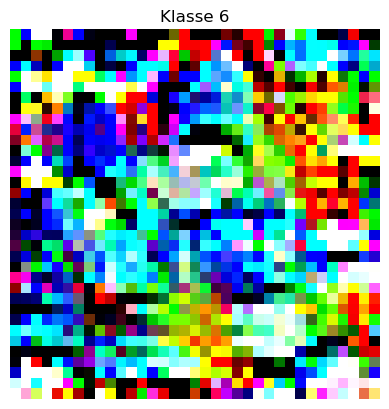

Klasse 7, Iteration 0/100, Verlust: 0.014866970479488373
Klasse 7, Iteration 10/100, Verlust: -42.749778747558594
Klasse 7, Iteration 20/100, Verlust: -72.72517395019531
Klasse 7, Iteration 30/100, Verlust: -84.27275085449219
Klasse 7, Iteration 40/100, Verlust: -89.41273498535156
Klasse 7, Iteration 50/100, Verlust: -92.90392303466797
Klasse 7, Iteration 60/100, Verlust: -95.13436889648438
Klasse 7, Iteration 70/100, Verlust: -96.37935638427734
Klasse 7, Iteration 80/100, Verlust: -97.33152770996094
Klasse 7, Iteration 90/100, Verlust: -97.95330810546875


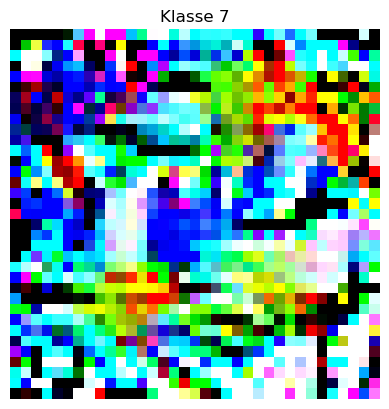

Klasse 8, Iteration 0/100, Verlust: 0.029407043009996414
Klasse 8, Iteration 10/100, Verlust: -59.08074188232422
Klasse 8, Iteration 20/100, Verlust: -105.33651733398438
Klasse 8, Iteration 30/100, Verlust: -118.61898803710938
Klasse 8, Iteration 40/100, Verlust: -124.51949310302734
Klasse 8, Iteration 50/100, Verlust: -128.00302124023438
Klasse 8, Iteration 60/100, Verlust: -129.813232421875
Klasse 8, Iteration 70/100, Verlust: -131.451904296875
Klasse 8, Iteration 80/100, Verlust: -132.40432739257812
Klasse 8, Iteration 90/100, Verlust: -132.88827514648438


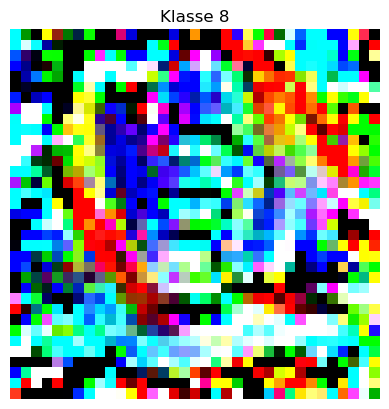

Klasse 9, Iteration 0/100, Verlust: 0.14832359552383423
Klasse 9, Iteration 10/100, Verlust: -37.90507507324219
Klasse 9, Iteration 20/100, Verlust: -63.605247497558594
Klasse 9, Iteration 30/100, Verlust: -71.88197326660156
Klasse 9, Iteration 40/100, Verlust: -76.22710418701172
Klasse 9, Iteration 50/100, Verlust: -78.39978790283203
Klasse 9, Iteration 60/100, Verlust: -79.80317687988281
Klasse 9, Iteration 70/100, Verlust: -80.79766845703125
Klasse 9, Iteration 80/100, Verlust: -81.27379608154297
Klasse 9, Iteration 90/100, Verlust: -81.51148986816406


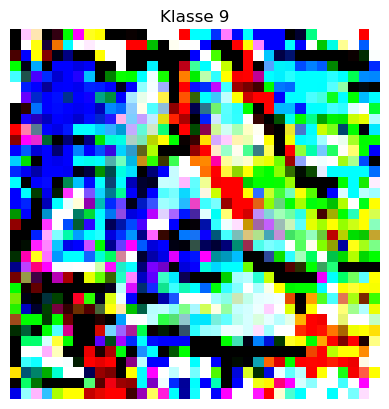

Klasse 10, Iteration 0/100, Verlust: -0.08957792818546295
Klasse 10, Iteration 10/100, Verlust: -32.33299255371094
Klasse 10, Iteration 20/100, Verlust: -61.4539909362793
Klasse 10, Iteration 30/100, Verlust: -72.90193176269531
Klasse 10, Iteration 40/100, Verlust: -78.3567886352539
Klasse 10, Iteration 50/100, Verlust: -81.26676940917969
Klasse 10, Iteration 60/100, Verlust: -82.9737548828125
Klasse 10, Iteration 70/100, Verlust: -83.91780090332031
Klasse 10, Iteration 80/100, Verlust: -84.4446029663086
Klasse 10, Iteration 90/100, Verlust: -84.8576431274414


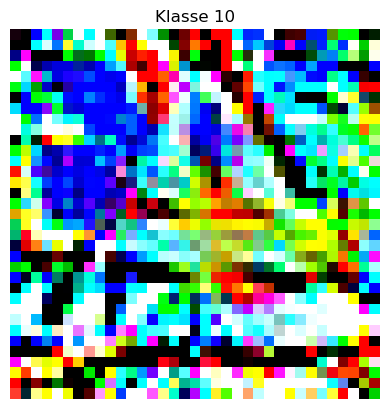

Klasse 11, Iteration 0/100, Verlust: -2.7280993461608887
Klasse 11, Iteration 10/100, Verlust: -39.37639236450195
Klasse 11, Iteration 20/100, Verlust: -62.421600341796875
Klasse 11, Iteration 30/100, Verlust: -70.10958099365234
Klasse 11, Iteration 40/100, Verlust: -74.69579315185547
Klasse 11, Iteration 50/100, Verlust: -77.47826385498047
Klasse 11, Iteration 60/100, Verlust: -79.82304382324219
Klasse 11, Iteration 70/100, Verlust: -81.01530456542969
Klasse 11, Iteration 80/100, Verlust: -81.78085327148438
Klasse 11, Iteration 90/100, Verlust: -82.35598754882812


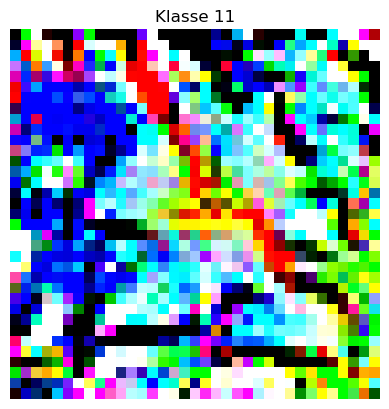

Klasse 12, Iteration 0/100, Verlust: 1.59755277633667
Klasse 12, Iteration 10/100, Verlust: -40.3875732421875
Klasse 12, Iteration 20/100, Verlust: -77.3926773071289
Klasse 12, Iteration 30/100, Verlust: -88.40513610839844
Klasse 12, Iteration 40/100, Verlust: -92.96895599365234
Klasse 12, Iteration 50/100, Verlust: -95.91212463378906
Klasse 12, Iteration 60/100, Verlust: -97.88086700439453
Klasse 12, Iteration 70/100, Verlust: -98.89240264892578
Klasse 12, Iteration 80/100, Verlust: -99.45059204101562
Klasse 12, Iteration 90/100, Verlust: -100.06511688232422


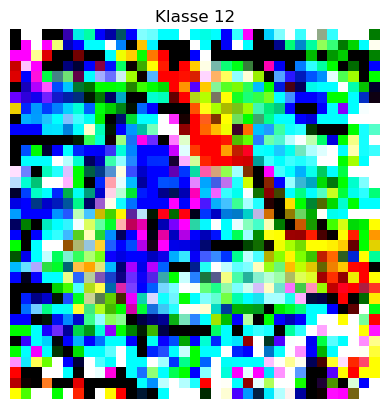

Klasse 13, Iteration 0/100, Verlust: -1.5163156986236572
Klasse 13, Iteration 10/100, Verlust: -56.09846496582031
Klasse 13, Iteration 20/100, Verlust: -89.78274536132812
Klasse 13, Iteration 30/100, Verlust: -102.63703155517578
Klasse 13, Iteration 40/100, Verlust: -108.18751525878906
Klasse 13, Iteration 50/100, Verlust: -110.7783203125
Klasse 13, Iteration 60/100, Verlust: -112.35429382324219
Klasse 13, Iteration 70/100, Verlust: -113.53153228759766
Klasse 13, Iteration 80/100, Verlust: -114.40302276611328
Klasse 13, Iteration 90/100, Verlust: -114.87200164794922


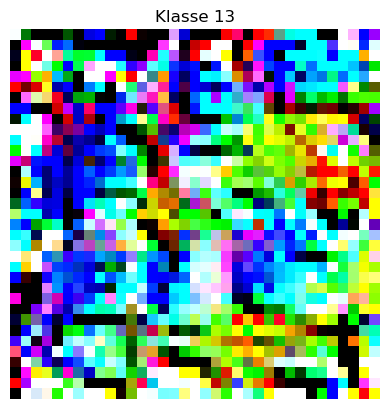

Klasse 14, Iteration 0/100, Verlust: -3.6105570793151855
Klasse 14, Iteration 10/100, Verlust: -83.0948486328125
Klasse 14, Iteration 20/100, Verlust: -121.765869140625
Klasse 14, Iteration 30/100, Verlust: -131.59889221191406
Klasse 14, Iteration 40/100, Verlust: -136.2002716064453
Klasse 14, Iteration 50/100, Verlust: -138.15609741210938
Klasse 14, Iteration 60/100, Verlust: -139.44369506835938
Klasse 14, Iteration 70/100, Verlust: -140.24868774414062
Klasse 14, Iteration 80/100, Verlust: -140.69363403320312
Klasse 14, Iteration 90/100, Verlust: -140.96156311035156


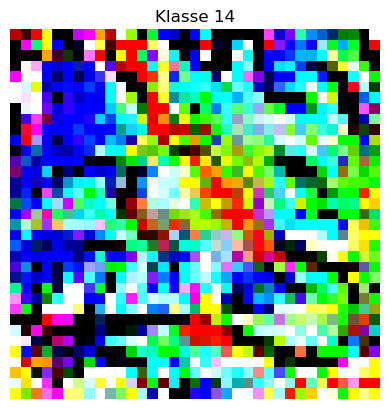

Klasse 15, Iteration 0/100, Verlust: -0.6361889839172363
Klasse 15, Iteration 10/100, Verlust: -50.8221549987793
Klasse 15, Iteration 20/100, Verlust: -75.02083587646484
Klasse 15, Iteration 30/100, Verlust: -82.7715072631836
Klasse 15, Iteration 40/100, Verlust: -86.1070556640625
Klasse 15, Iteration 50/100, Verlust: -88.57495880126953
Klasse 15, Iteration 60/100, Verlust: -90.10066986083984
Klasse 15, Iteration 70/100, Verlust: -91.21923828125
Klasse 15, Iteration 80/100, Verlust: -92.3297348022461
Klasse 15, Iteration 90/100, Verlust: -93.19668579101562


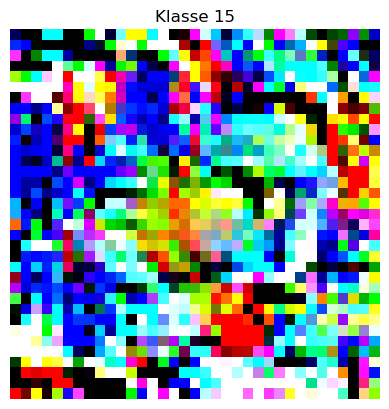

Klasse 16, Iteration 0/100, Verlust: 0.5094562768936157
Klasse 16, Iteration 10/100, Verlust: -56.59482192993164
Klasse 16, Iteration 20/100, Verlust: -91.60206604003906
Klasse 16, Iteration 30/100, Verlust: -101.92910766601562
Klasse 16, Iteration 40/100, Verlust: -105.88338470458984
Klasse 16, Iteration 50/100, Verlust: -107.83200073242188
Klasse 16, Iteration 60/100, Verlust: -109.15065002441406
Klasse 16, Iteration 70/100, Verlust: -110.30200958251953
Klasse 16, Iteration 80/100, Verlust: -111.24591827392578
Klasse 16, Iteration 90/100, Verlust: -112.05715942382812


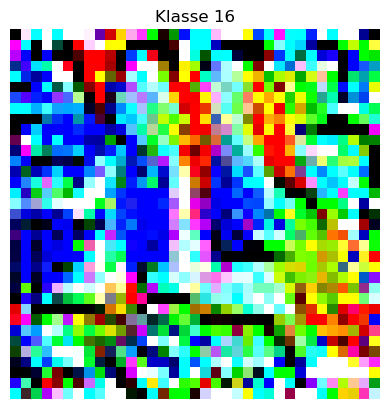

Klasse 17, Iteration 0/100, Verlust: 0.8253721594810486
Klasse 17, Iteration 10/100, Verlust: -45.866737365722656
Klasse 17, Iteration 20/100, Verlust: -72.11922454833984
Klasse 17, Iteration 30/100, Verlust: -79.29810333251953
Klasse 17, Iteration 40/100, Verlust: -83.28770446777344
Klasse 17, Iteration 50/100, Verlust: -85.65679931640625
Klasse 17, Iteration 60/100, Verlust: -86.80878448486328
Klasse 17, Iteration 70/100, Verlust: -87.78419494628906
Klasse 17, Iteration 80/100, Verlust: -88.32605743408203
Klasse 17, Iteration 90/100, Verlust: -88.76531982421875


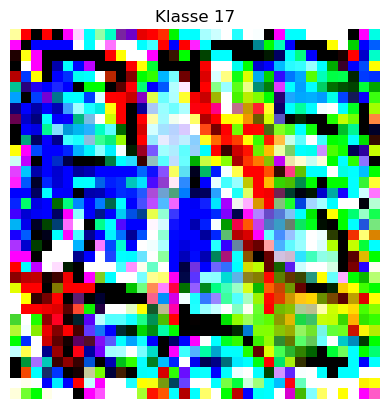

Klasse 18, Iteration 0/100, Verlust: -0.5160088539123535
Klasse 18, Iteration 10/100, Verlust: -51.64095687866211
Klasse 18, Iteration 20/100, Verlust: -95.81616973876953
Klasse 18, Iteration 30/100, Verlust: -113.58575439453125
Klasse 18, Iteration 40/100, Verlust: -121.16096496582031
Klasse 18, Iteration 50/100, Verlust: -125.21050262451172
Klasse 18, Iteration 60/100, Verlust: -127.78807067871094
Klasse 18, Iteration 70/100, Verlust: -129.1310577392578
Klasse 18, Iteration 80/100, Verlust: -129.95542907714844
Klasse 18, Iteration 90/100, Verlust: -130.51576232910156


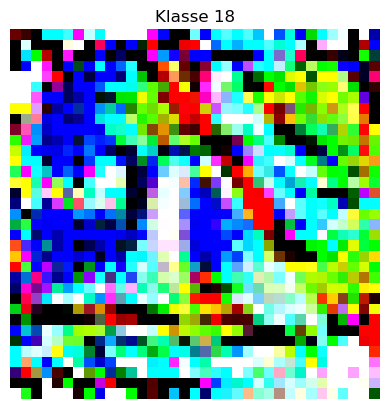

Klasse 19, Iteration 0/100, Verlust: 1.948291301727295
Klasse 19, Iteration 10/100, Verlust: -42.84618377685547
Klasse 19, Iteration 20/100, Verlust: -80.73124694824219
Klasse 19, Iteration 30/100, Verlust: -94.28843688964844
Klasse 19, Iteration 40/100, Verlust: -99.57501983642578
Klasse 19, Iteration 50/100, Verlust: -101.72325897216797
Klasse 19, Iteration 60/100, Verlust: -102.71855926513672
Klasse 19, Iteration 70/100, Verlust: -103.23844146728516
Klasse 19, Iteration 80/100, Verlust: -103.59075927734375
Klasse 19, Iteration 90/100, Verlust: -103.76783752441406


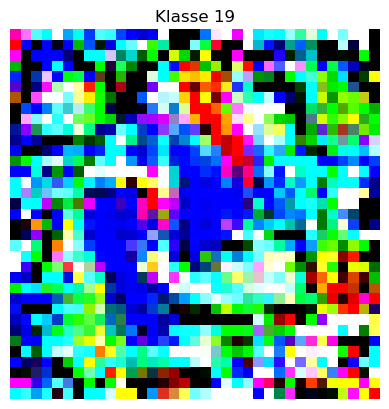

Klasse 20, Iteration 0/100, Verlust: 1.243207573890686
Klasse 20, Iteration 10/100, Verlust: -44.09809875488281
Klasse 20, Iteration 20/100, Verlust: -86.51557159423828
Klasse 20, Iteration 30/100, Verlust: -100.64607238769531
Klasse 20, Iteration 40/100, Verlust: -107.00780487060547
Klasse 20, Iteration 50/100, Verlust: -110.63682556152344
Klasse 20, Iteration 60/100, Verlust: -114.67495727539062
Klasse 20, Iteration 70/100, Verlust: -117.06110382080078
Klasse 20, Iteration 80/100, Verlust: -118.52012634277344
Klasse 20, Iteration 90/100, Verlust: -119.65650177001953


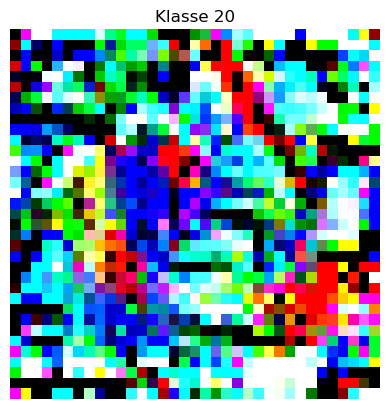

Klasse 21, Iteration 0/100, Verlust: 0.5837012529373169
Klasse 21, Iteration 10/100, Verlust: -40.1035270690918
Klasse 21, Iteration 20/100, Verlust: -72.0987777709961
Klasse 21, Iteration 30/100, Verlust: -81.7337417602539
Klasse 21, Iteration 40/100, Verlust: -86.3935775756836
Klasse 21, Iteration 50/100, Verlust: -89.29955291748047
Klasse 21, Iteration 60/100, Verlust: -90.99982452392578
Klasse 21, Iteration 70/100, Verlust: -92.14605712890625
Klasse 21, Iteration 80/100, Verlust: -92.8035659790039
Klasse 21, Iteration 90/100, Verlust: -93.26441955566406


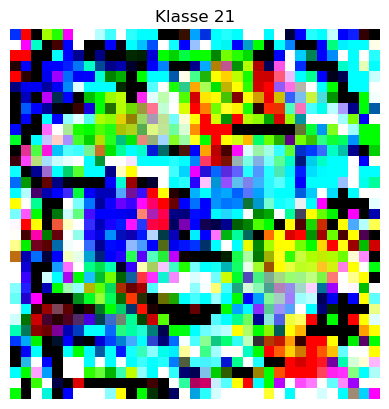

Klasse 22, Iteration 0/100, Verlust: 1.2758852243423462
Klasse 22, Iteration 10/100, Verlust: -31.57175636291504
Klasse 22, Iteration 20/100, Verlust: -52.86822509765625
Klasse 22, Iteration 30/100, Verlust: -59.647281646728516
Klasse 22, Iteration 40/100, Verlust: -62.69523239135742
Klasse 22, Iteration 50/100, Verlust: -64.78352355957031
Klasse 22, Iteration 60/100, Verlust: -66.5036849975586
Klasse 22, Iteration 70/100, Verlust: -68.07293701171875
Klasse 22, Iteration 80/100, Verlust: -69.58168029785156
Klasse 22, Iteration 90/100, Verlust: -70.95881652832031


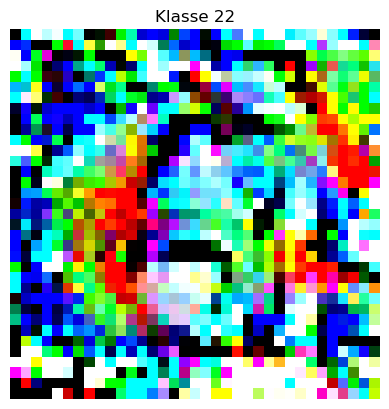

Klasse 23, Iteration 0/100, Verlust: -0.5068499445915222
Klasse 23, Iteration 10/100, Verlust: -41.65141296386719
Klasse 23, Iteration 20/100, Verlust: -78.6651611328125
Klasse 23, Iteration 30/100, Verlust: -91.42639923095703
Klasse 23, Iteration 40/100, Verlust: -97.16463470458984
Klasse 23, Iteration 50/100, Verlust: -100.64000701904297
Klasse 23, Iteration 60/100, Verlust: -102.6751937866211
Klasse 23, Iteration 70/100, Verlust: -103.78557586669922
Klasse 23, Iteration 80/100, Verlust: -104.73072814941406
Klasse 23, Iteration 90/100, Verlust: -105.20558166503906


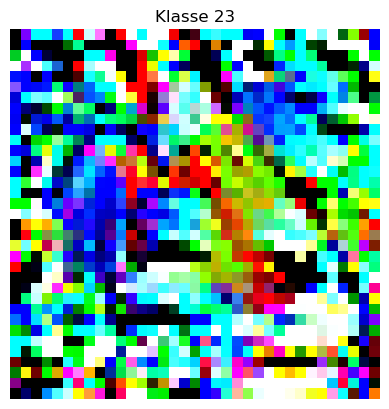

Klasse 24, Iteration 0/100, Verlust: 1.9706099033355713
Klasse 24, Iteration 10/100, Verlust: -50.42830276489258
Klasse 24, Iteration 20/100, Verlust: -90.41606140136719
Klasse 24, Iteration 30/100, Verlust: -103.21109008789062
Klasse 24, Iteration 40/100, Verlust: -108.56546783447266
Klasse 24, Iteration 50/100, Verlust: -111.2612533569336
Klasse 24, Iteration 60/100, Verlust: -112.9973373413086
Klasse 24, Iteration 70/100, Verlust: -114.14546966552734
Klasse 24, Iteration 80/100, Verlust: -114.84675598144531
Klasse 24, Iteration 90/100, Verlust: -115.37950897216797


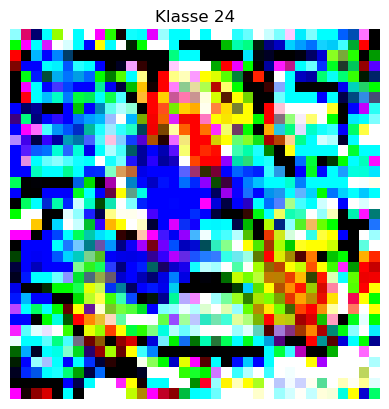

Klasse 25, Iteration 0/100, Verlust: 0.04773956537246704
Klasse 25, Iteration 10/100, Verlust: -37.284603118896484
Klasse 25, Iteration 20/100, Verlust: -75.2881088256836
Klasse 25, Iteration 30/100, Verlust: -87.35195922851562
Klasse 25, Iteration 40/100, Verlust: -92.20951080322266
Klasse 25, Iteration 50/100, Verlust: -94.43360137939453
Klasse 25, Iteration 60/100, Verlust: -95.89598846435547
Klasse 25, Iteration 70/100, Verlust: -96.67088317871094
Klasse 25, Iteration 80/100, Verlust: -97.22219848632812
Klasse 25, Iteration 90/100, Verlust: -97.82521057128906


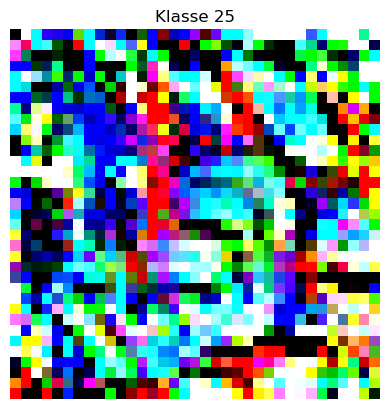

Klasse 26, Iteration 0/100, Verlust: 1.0678683519363403
Klasse 26, Iteration 10/100, Verlust: -37.620140075683594
Klasse 26, Iteration 20/100, Verlust: -60.45689392089844
Klasse 26, Iteration 30/100, Verlust: -67.63099670410156
Klasse 26, Iteration 40/100, Verlust: -71.4041748046875
Klasse 26, Iteration 50/100, Verlust: -74.09065246582031
Klasse 26, Iteration 60/100, Verlust: -75.92424774169922
Klasse 26, Iteration 70/100, Verlust: -77.17659759521484
Klasse 26, Iteration 80/100, Verlust: -78.16238403320312
Klasse 26, Iteration 90/100, Verlust: -78.79163360595703


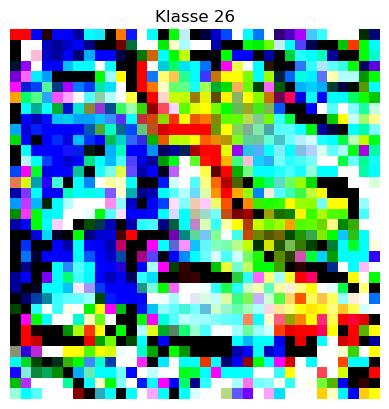

Klasse 27, Iteration 0/100, Verlust: -1.3155405521392822
Klasse 27, Iteration 10/100, Verlust: -77.1138687133789
Klasse 27, Iteration 20/100, Verlust: -118.30938720703125
Klasse 27, Iteration 30/100, Verlust: -130.00225830078125
Klasse 27, Iteration 40/100, Verlust: -135.9920196533203
Klasse 27, Iteration 50/100, Verlust: -140.13294982910156
Klasse 27, Iteration 60/100, Verlust: -142.96038818359375
Klasse 27, Iteration 70/100, Verlust: -144.65553283691406
Klasse 27, Iteration 80/100, Verlust: -145.8754425048828
Klasse 27, Iteration 90/100, Verlust: -147.04043579101562


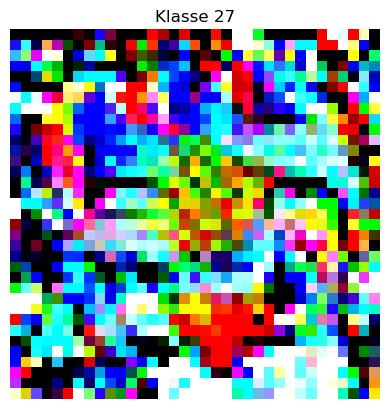

Klasse 28, Iteration 0/100, Verlust: -1.489601731300354
Klasse 28, Iteration 10/100, Verlust: -62.88718032836914
Klasse 28, Iteration 20/100, Verlust: -95.22962951660156
Klasse 28, Iteration 30/100, Verlust: -107.63347625732422
Klasse 28, Iteration 40/100, Verlust: -114.60429382324219
Klasse 28, Iteration 50/100, Verlust: -118.1041259765625
Klasse 28, Iteration 60/100, Verlust: -120.01203155517578
Klasse 28, Iteration 70/100, Verlust: -121.56238555908203
Klasse 28, Iteration 80/100, Verlust: -123.12147521972656
Klasse 28, Iteration 90/100, Verlust: -123.85186767578125


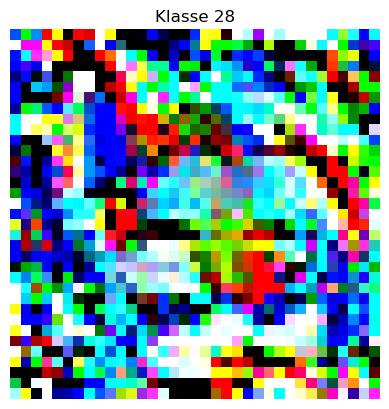

Klasse 29, Iteration 0/100, Verlust: -1.5026218891143799
Klasse 29, Iteration 10/100, Verlust: -56.23944091796875
Klasse 29, Iteration 20/100, Verlust: -87.19921875
Klasse 29, Iteration 30/100, Verlust: -95.5108871459961
Klasse 29, Iteration 40/100, Verlust: -99.22607421875
Klasse 29, Iteration 50/100, Verlust: -101.39320373535156
Klasse 29, Iteration 60/100, Verlust: -102.68279266357422
Klasse 29, Iteration 70/100, Verlust: -103.54259490966797
Klasse 29, Iteration 80/100, Verlust: -104.34217834472656
Klasse 29, Iteration 90/100, Verlust: -104.96135711669922


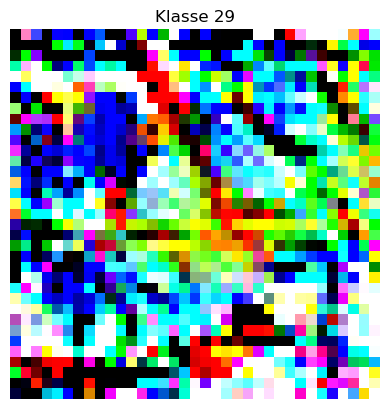

Klasse 30, Iteration 0/100, Verlust: -2.3323168754577637
Klasse 30, Iteration 10/100, Verlust: -44.65945053100586
Klasse 30, Iteration 20/100, Verlust: -68.46429443359375
Klasse 30, Iteration 30/100, Verlust: -76.82350158691406
Klasse 30, Iteration 40/100, Verlust: -80.90377807617188
Klasse 30, Iteration 50/100, Verlust: -83.15890502929688
Klasse 30, Iteration 60/100, Verlust: -84.4634780883789
Klasse 30, Iteration 70/100, Verlust: -85.7142333984375
Klasse 30, Iteration 80/100, Verlust: -87.09474182128906
Klasse 30, Iteration 90/100, Verlust: -88.44619750976562


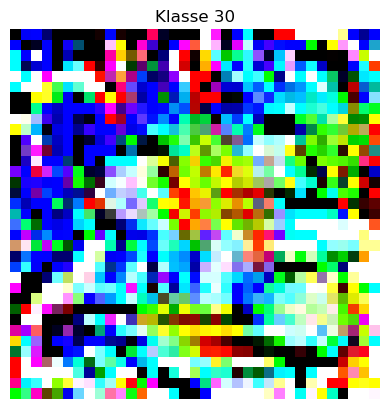

Klasse 31, Iteration 0/100, Verlust: -1.6497726440429688
Klasse 31, Iteration 10/100, Verlust: -69.94158935546875
Klasse 31, Iteration 20/100, Verlust: -100.6862564086914
Klasse 31, Iteration 30/100, Verlust: -110.02119445800781
Klasse 31, Iteration 40/100, Verlust: -114.075927734375
Klasse 31, Iteration 50/100, Verlust: -117.0552749633789
Klasse 31, Iteration 60/100, Verlust: -119.9628677368164
Klasse 31, Iteration 70/100, Verlust: -121.76229095458984
Klasse 31, Iteration 80/100, Verlust: -122.95805358886719
Klasse 31, Iteration 90/100, Verlust: -123.66664123535156


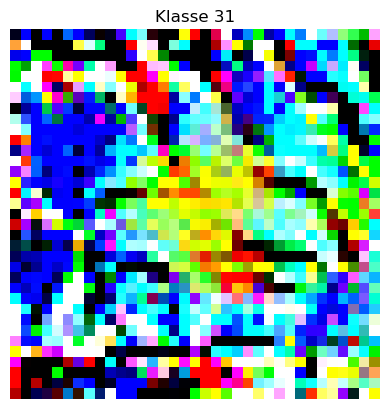

Klasse 32, Iteration 0/100, Verlust: -1.2284319400787354
Klasse 32, Iteration 10/100, Verlust: -61.65030288696289
Klasse 32, Iteration 20/100, Verlust: -101.04415130615234
Klasse 32, Iteration 30/100, Verlust: -115.77589416503906
Klasse 32, Iteration 40/100, Verlust: -123.4318618774414
Klasse 32, Iteration 50/100, Verlust: -128.49551391601562
Klasse 32, Iteration 60/100, Verlust: -131.10765075683594
Klasse 32, Iteration 70/100, Verlust: -132.55357360839844
Klasse 32, Iteration 80/100, Verlust: -133.34852600097656
Klasse 32, Iteration 90/100, Verlust: -133.96681213378906


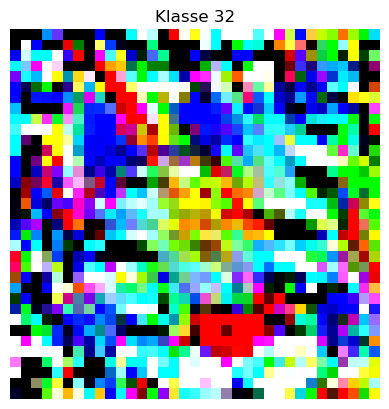

Klasse 33, Iteration 0/100, Verlust: -0.7104701399803162
Klasse 33, Iteration 10/100, Verlust: -43.33039093017578
Klasse 33, Iteration 20/100, Verlust: -67.86339569091797
Klasse 33, Iteration 30/100, Verlust: -77.56861114501953
Klasse 33, Iteration 40/100, Verlust: -82.20946502685547
Klasse 33, Iteration 50/100, Verlust: -84.85613250732422
Klasse 33, Iteration 60/100, Verlust: -86.74932098388672
Klasse 33, Iteration 70/100, Verlust: -88.10676574707031
Klasse 33, Iteration 80/100, Verlust: -88.9320068359375
Klasse 33, Iteration 90/100, Verlust: -89.53345489501953


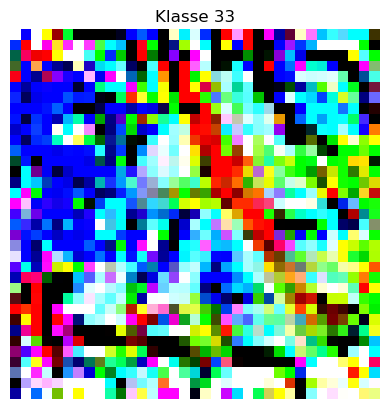

Klasse 34, Iteration 0/100, Verlust: 0.44538578391075134
Klasse 34, Iteration 10/100, Verlust: -19.137897491455078
Klasse 34, Iteration 20/100, Verlust: -35.550018310546875
Klasse 34, Iteration 30/100, Verlust: -40.869476318359375
Klasse 34, Iteration 40/100, Verlust: -43.249794006347656
Klasse 34, Iteration 50/100, Verlust: -44.553619384765625
Klasse 34, Iteration 60/100, Verlust: -45.46317672729492
Klasse 34, Iteration 70/100, Verlust: -46.11013412475586
Klasse 34, Iteration 80/100, Verlust: -46.753990173339844
Klasse 34, Iteration 90/100, Verlust: -47.1825065612793


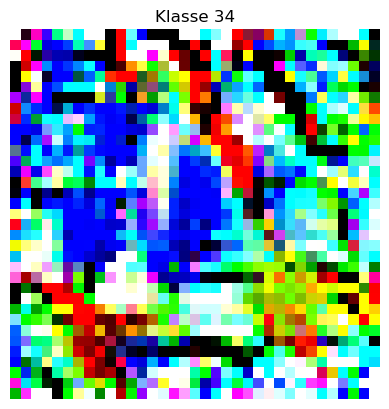

Klasse 35, Iteration 0/100, Verlust: 1.0128965377807617
Klasse 35, Iteration 10/100, Verlust: -53.530860900878906
Klasse 35, Iteration 20/100, Verlust: -97.3204116821289
Klasse 35, Iteration 30/100, Verlust: -108.84169006347656
Klasse 35, Iteration 40/100, Verlust: -114.3331298828125
Klasse 35, Iteration 50/100, Verlust: -117.176025390625
Klasse 35, Iteration 60/100, Verlust: -119.01036071777344
Klasse 35, Iteration 70/100, Verlust: -120.26705932617188
Klasse 35, Iteration 80/100, Verlust: -121.46920013427734
Klasse 35, Iteration 90/100, Verlust: -122.56475830078125


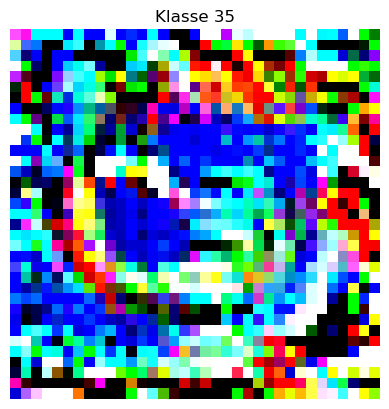

Klasse 36, Iteration 0/100, Verlust: -3.9594829082489014
Klasse 36, Iteration 10/100, Verlust: -82.35507202148438
Klasse 36, Iteration 20/100, Verlust: -121.8751449584961
Klasse 36, Iteration 30/100, Verlust: -134.04592895507812
Klasse 36, Iteration 40/100, Verlust: -140.4706573486328
Klasse 36, Iteration 50/100, Verlust: -144.7745361328125
Klasse 36, Iteration 60/100, Verlust: -147.26248168945312
Klasse 36, Iteration 70/100, Verlust: -148.9165496826172
Klasse 36, Iteration 80/100, Verlust: -150.33596801757812
Klasse 36, Iteration 90/100, Verlust: -151.452392578125


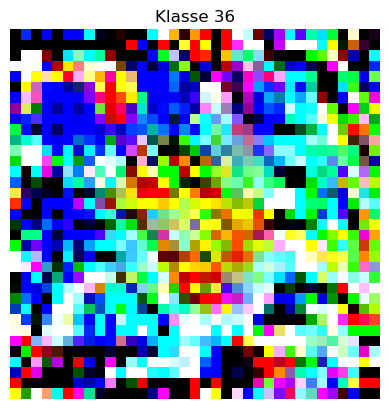

Klasse 37, Iteration 0/100, Verlust: -2.940620183944702
Klasse 37, Iteration 10/100, Verlust: -79.8958740234375
Klasse 37, Iteration 20/100, Verlust: -117.60173034667969
Klasse 37, Iteration 30/100, Verlust: -132.7260284423828
Klasse 37, Iteration 40/100, Verlust: -140.56968688964844
Klasse 37, Iteration 50/100, Verlust: -144.9365692138672
Klasse 37, Iteration 60/100, Verlust: -148.05670166015625
Klasse 37, Iteration 70/100, Verlust: -150.24453735351562
Klasse 37, Iteration 80/100, Verlust: -151.75140380859375
Klasse 37, Iteration 90/100, Verlust: -152.859130859375


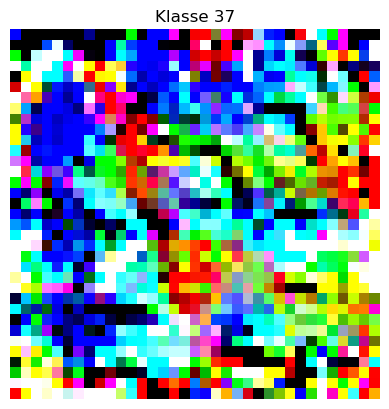

Klasse 38, Iteration 0/100, Verlust: -0.3869481384754181
Klasse 38, Iteration 10/100, Verlust: -49.79658508300781
Klasse 38, Iteration 20/100, Verlust: -85.5796127319336
Klasse 38, Iteration 30/100, Verlust: -97.25898742675781
Klasse 38, Iteration 40/100, Verlust: -101.9360580444336
Klasse 38, Iteration 50/100, Verlust: -104.48226165771484
Klasse 38, Iteration 60/100, Verlust: -106.1072006225586
Klasse 38, Iteration 70/100, Verlust: -106.91871643066406
Klasse 38, Iteration 80/100, Verlust: -107.49187469482422
Klasse 38, Iteration 90/100, Verlust: -107.85918426513672


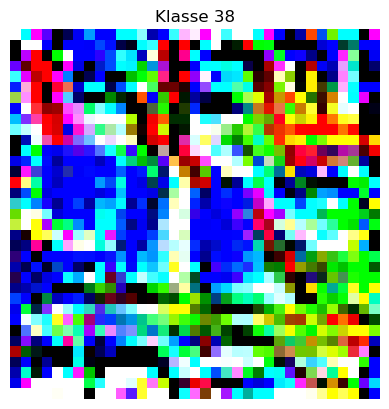

Klasse 39, Iteration 0/100, Verlust: 1.8514306545257568
Klasse 39, Iteration 10/100, Verlust: -34.59782409667969
Klasse 39, Iteration 20/100, Verlust: -60.572166442871094
Klasse 39, Iteration 30/100, Verlust: -68.55570220947266
Klasse 39, Iteration 40/100, Verlust: -72.24594116210938
Klasse 39, Iteration 50/100, Verlust: -74.37210083007812
Klasse 39, Iteration 60/100, Verlust: -75.51624298095703
Klasse 39, Iteration 70/100, Verlust: -76.35525512695312
Klasse 39, Iteration 80/100, Verlust: -76.81217193603516
Klasse 39, Iteration 90/100, Verlust: -77.16117095947266


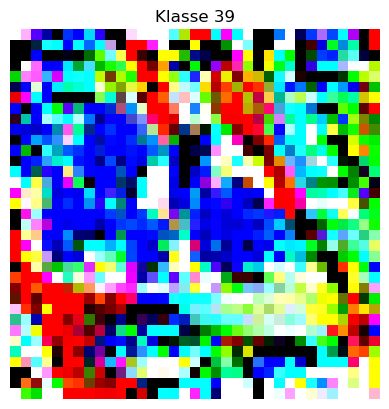

Klasse 40, Iteration 0/100, Verlust: 1.0275112390518188
Klasse 40, Iteration 10/100, Verlust: -44.374473571777344
Klasse 40, Iteration 20/100, Verlust: -82.3816146850586
Klasse 40, Iteration 30/100, Verlust: -95.51070404052734
Klasse 40, Iteration 40/100, Verlust: -100.3334732055664
Klasse 40, Iteration 50/100, Verlust: -103.4878158569336
Klasse 40, Iteration 60/100, Verlust: -105.80319213867188
Klasse 40, Iteration 70/100, Verlust: -107.8154296875
Klasse 40, Iteration 80/100, Verlust: -109.27964782714844
Klasse 40, Iteration 90/100, Verlust: -110.39268493652344


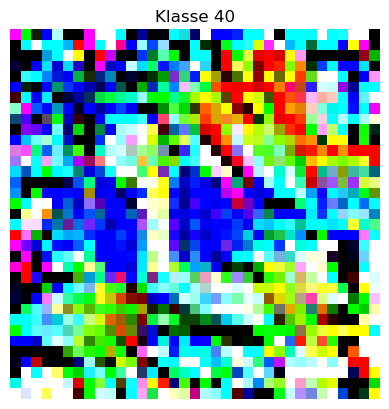

Klasse 41, Iteration 0/100, Verlust: 0.7276384830474854
Klasse 41, Iteration 10/100, Verlust: -32.5648193359375
Klasse 41, Iteration 20/100, Verlust: -59.867610931396484
Klasse 41, Iteration 30/100, Verlust: -67.344482421875
Klasse 41, Iteration 40/100, Verlust: -71.7225570678711
Klasse 41, Iteration 50/100, Verlust: -74.77813720703125
Klasse 41, Iteration 60/100, Verlust: -76.03177642822266
Klasse 41, Iteration 70/100, Verlust: -76.93174743652344
Klasse 41, Iteration 80/100, Verlust: -77.66249084472656
Klasse 41, Iteration 90/100, Verlust: -78.18862915039062


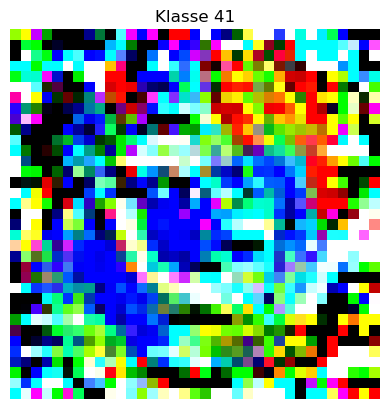

Klasse 42, Iteration 0/100, Verlust: 0.7698769569396973
Klasse 42, Iteration 10/100, Verlust: -55.93134689331055
Klasse 42, Iteration 20/100, Verlust: -99.43572235107422
Klasse 42, Iteration 30/100, Verlust: -113.38735961914062
Klasse 42, Iteration 40/100, Verlust: -118.73632049560547
Klasse 42, Iteration 50/100, Verlust: -121.58103942871094
Klasse 42, Iteration 60/100, Verlust: -123.22399139404297
Klasse 42, Iteration 70/100, Verlust: -124.05709075927734
Klasse 42, Iteration 80/100, Verlust: -124.6838607788086
Klasse 42, Iteration 90/100, Verlust: -125.16093444824219


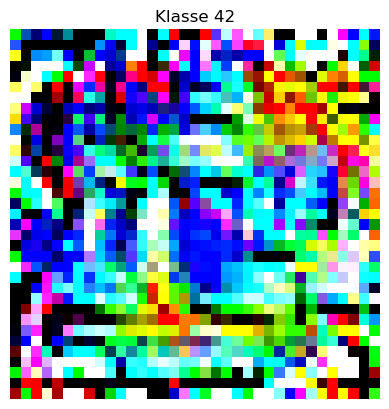

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import os

# Neuron auswählen
target_neuron = 1  # Index des gewünschten Neurons (z. B. in der letzten Fully Connected Layer)
print(train_dataset.classes[target_neuron])

# Zufälliges Startbild erzeugen
input_image = torch.randn(1, 3, 35, 35, requires_grad=True, device=device)  # Für 32x32 RGB-Bilder

# Anzahl der Klassen in Ihrem Modell
num_classes = 43  # Passen Sie dies an, falls notwendig

# Eingabegröße Ihres Modells
input_size = (1, 3, 35, 35)  # Passen Sie die Größe an Ihr Modell an

# Ordner erstellen, um die Bilder zu speichern
os.makedirs('max_class_images', exist_ok=True)

# Für jede Klasse ein Bild generieren
for class_idx in range(num_classes):
    # Erstellen Sie ein zufälliges Eingabebild mit Gradienten
    input_image = torch.randn(input_size, requires_grad=True, device=device)
    
    # Definieren Sie den Optimierer
    optimizer = optim.Adam([input_image], lr=0.1)
    
    # Hauptoptimierungsschleife
    num_iterations = 100
    for i in range(num_iterations):
        optimizer.zero_grad()
        output = trained_model(input_image)
        # Die Ausgabe ist der Logit für jede Klasse
        class_score = output[0, class_idx]
        # Wir wollen den Klassenscore maximieren
        loss = -class_score
        loss.backward()
        optimizer.step()
        # Eingabebildwerte beschränken
        input_image.data.clamp_(0, 1)
        if i % 10 == 0:
            print(f'Klasse {class_idx}, Iteration {i}/{num_iterations}, Verlust: {loss.item()}')
    
    # Ergebnis visualisieren
    result = input_image.detach().cpu().squeeze().permute(1, 2, 0).numpy()
    # Normalisieren Sie das Bild für die Darstellung
    result = (result - result.min()) / (result.max() - result.min())
    
    plt.imshow(result)
    plt.axis('off')
    plt.title(f'Klasse {class_idx}')
    plt.show()
    
    # Bild speichern
    plt.imsave(f'max_class_images/klasse_{class_idx}.png', result)


In [34]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np

# Stellen Sie sicher, dass Ihr Modell im Evaluationsmodus ist
trained_model.eval()

# Gerät konfigurieren (CPU oder GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model.to(device)

# Transformationen definieren, die auf das Bild angewendet werden
transform = transforms.Compose([
    transforms.Resize((35, 35)),  # Passen Sie die Größe an die des Modells an
    transforms.ToTensor(),        # Konvertieren Sie das Bild in einen Tensor
    # Optional: Normalisierung hinzufügen, falls Ihr Modell dies erfordert
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225])
])

# Optional: Liste der Klassennamen definieren
class_names = [
    'Geschwindigkeitsbegrenzung (20km/h)',
    'Geschwindigkeitsbegrenzung (30km/h)',
    'Geschwindigkeitsbegrenzung (50km/h)',
    # ... fügen Sie alle 43 Klassennamen hinzu
    'Andere Gefahren'
]

def predict_image_class(image_path):
    """
    Lädt ein Bild, transformiert es und gibt die Wahrscheinlichkeiten der Top-3-Klassen zurück.
    """
    # Bild laden
    image = Image.open(image_path).convert('RGB')
    
    # Bild transformieren
    image_tensor = transform(image).unsqueeze(0).to(device)  # Batch-Dimension hinzufügen
    
    # Vorhersage durchführen
    with torch.no_grad():
        output = trained_model(image_tensor)
        # Wahrscheinlichkeiten berechnen
        probabilities = torch.softmax(output, dim=1)
        # Top-3-Klassen und -Wahrscheinlichkeiten erhalten
        top_probs, top_indices = torch.topk(probabilities, 3)
        top_probs = top_probs.cpu().numpy()[0]
        top_indices = top_indices.cpu().numpy()[0]
    
    # Ergebnisse als Liste von Tupeln (Klassenindex, Wahrscheinlichkeit) zurückgeben
    top_classes = [(int(idx), float(prob)) for idx, prob in zip(top_indices, top_probs)]
    return top_classes

# Beispielverwendung
image_path = 'output.png'  # Geben Sie den Pfad zu Ihrem Bild an
top_classes = predict_image_class(image_path)

# Ergebnisse ausgeben
print('Die Top-3-Klassen sind:')
for idx, prob in top_classes:
    if idx < len(class_names):
        class_name = class_names[idx]
    else:
        class_name = f'Klasse {idx}'
    print(f'{class_name}: {prob * 100:.2f}% Wahrscheinlichkeit')


Die Top-3-Klassen sind:
Klasse 42: 100.00% Wahrscheinlichkeit
Geschwindigkeitsbegrenzung (20km/h): 0.00% Wahrscheinlichkeit
Klasse 6: 0.00% Wahrscheinlichkeit


### More

Die 3 stärksten aktivierten Neuronen in fc9:
1. Neuron 13: Aktivierung = 19.6559
2. Neuron 18: Aktivierung = 15.3731
3. Neuron 37: Aktivierung = 12.9891


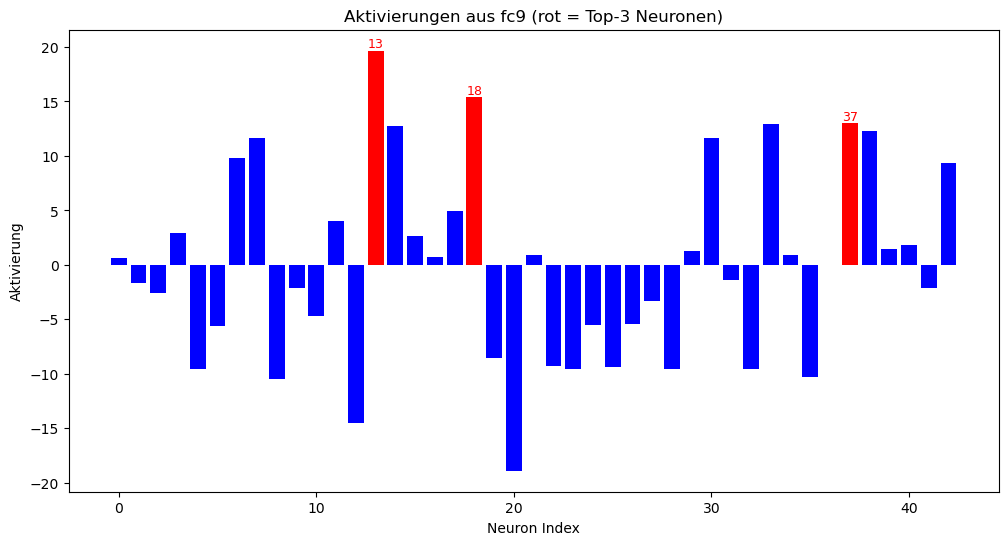

In [76]:
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_fc_layer_with_path_and_top_neurons(model, layer_name, image_path, top_n=5):
    model.eval()
    activations = {}

    # Hook für das gewünschte Layer
    def hook_fn(module, input, output):
        activations[layer_name] = output

    # Layer abrufen und Hook setzen
    target_layer = dict(model.named_modules())[layer_name]
    target_layer.register_forward_hook(hook_fn)

    # Bild laden und transformieren
    transform = transforms.Compose([
        transforms.Resize((35, 35)),  
        transforms.ToTensor(),      
    ])
    image = Image.open(image_path).convert('RGB')
    input_image = transform(image).unsqueeze(0).to(next(model.parameters()).device)  # Auf Batch-Dimension erweitern

    # Bild durch das Modell schicken
    with torch.no_grad():
        model(input_image)

    features = activations[layer_name][0].cpu().detach().numpy()

    top_indices = np.argsort(features)[-top_n:][::-1]  
    top_activations = features[top_indices]  

    print(f"Die {top_n} stärksten aktivierten Neuronen in {layer_name}:")
    for i, idx in enumerate(top_indices):
        print(f"{i+1}. Neuron {idx}: Aktivierung = {top_activations[i]:.4f}")

    plt.figure(figsize=(12, 6))
    colors = ['red' if i in top_indices else 'blue' for i in range(len(features))]
    plt.bar(range(len(features)), features, color=colors)
    plt.title(f'Aktivierungen aus {layer_name} (rot = Top-{top_n} Neuronen)')
    plt.xlabel('Neuron Index')
    plt.ylabel('Aktivierung')

    for i, idx in enumerate(top_indices):
        plt.text(idx, features[idx], f"{idx}", ha='center', va='bottom', fontsize=9, color='red')

    plt.show()

image_path = 'GTSRB/Final_Test/Images/ampel/00057.ppm'  
visualize_fc_layer_with_path_and_top_neurons(trained_model, 'fc9', image_path, top_n=3)
